## Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import Math
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

plt.style.use("~/geoscience/carbon_estimation/MNRAS.mplstyle")
%matplotlib inline

## Load the Data

In [3]:
target_cols = ["icesat2_h_mean_canopy", "gedi_rh_80"]
use_cols = [# "gedi_northing", "gedi_easting", "icesat2_northing", "icesat2_easting",
            "gedi_quality_flag", "gedi_num_detectedmodes", "gedi_fhd_normal", "gedi_rx_sample_count", "gedi_sensitivity", 
            "icesat2_num_bins", "icesat2_ph_count", "icesat2_gnd_ph_count", "icesat2_veg_ph_count",
            "icesat2_h_mean_canopy", "gedi_rh_80"]# "gedi_rh_100"]

coregistered_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/"
coregistered_file = "coregistered.csv"
pd.set_option("display.max_columns", None)
coregistered_data = pd.read_csv(os.path.join(coregistered_dir, coregistered_file))

print(coregistered_data.shape)
coregistered_data.columns

(610, 29)


Index(['gedi_northing', 'gedi_easting', 'icesat2_northing', 'icesat2_easting',
       'gedi_elevation', 'icesat2_elevation', 'gedi_date', 'icesat2_date',
       'icesat2_spot', 'icesat2_gnd_ph_count', 'icesat2_h_mean_canopy',
       'icesat2_ph_count', 'icesat2_veg_ph_count', 'icesat2_solar_elevation',
       'icesat2_landcover', 'icesat2_num_bins', 'icesat2_slope_degrees',
       'gedi_quality_flag', 'gedi_num_detectedmodes', 'gedi_rh_80',
       'gedi_rh_100', 'gedi_solar_elevation', 'gedi_slope_degrees',
       'gedi_rx_sample_count', 'gedi_cover_z_29', 'gedi_fhd_normal',
       'gedi_pai_z_29', 'gedi_pavd_z_29', 'gedi_sensitivity'],
      dtype='object')

### Data Quality Filtering

In [5]:
coregistered_data = coregistered_data[coregistered_data["gedi_rh_80"] <= 15]
coregistered_data = coregistered_data[coregistered_data["gedi_fhd_normal"] != -9999.000000]
coregistered_data = coregistered_data[coregistered_data["gedi_elevation"] >= 1000] # remove unrealistic/degraded data points with very low elevation.
coregistered_data = coregistered_data[coregistered_data["icesat2_elevation"] >= 1000] # remove unrealistic/degraded data points with very low elevation.
coregistered_data = coregistered_data[coregistered_data["icesat2_gnd_ph_count"] != 0]
coregistered_data = coregistered_data[coregistered_data["icesat2_h_mean_canopy"] <= 15]

coregistered_data_ml = coregistered_data[use_cols]
display(len(coregistered_data_ml))
display(coregistered_data_ml.head())

477

,gedi_quality_flag,gedi_num_detectedmodes,gedi_fhd_normal,gedi_rx_sample_count,gedi_sensitivity,icesat2_num_bins,icesat2_ph_count,icesat2_gnd_ph_count,icesat2_veg_ph_count,icesat2_h_mean_canopy,gedi_rh_80
4,1,1,1.610795,765.0,0.962840,15,142,39,103,3.125991,1.23
5,1,2,2.712556,828.0,0.954226,18,136,93,43,6.023770,3.17
6,1,1,1.581037,753.0,0.955018,5,219,60,159,1.624177,1.23
7,1,1,1.562571,756.0,0.962132,13,80,10,70,3.992998,1.15
9,1,1,1.992453,786.0,0.953893,4,52,29,23,2.467046,1.86


## Random Forest (RF) Model - ICESat-2
### Train-Test Split

In [7]:
# The first column is categorical
categorical_features = [0]  # index of the categorical column
numerical_features = list(range(1, coregistered_data_ml.shape[1] - 2))  # last 2 columns are the target variables

# Reshuffle data
coregistered_data_ml_shuffle = shuffle(coregistered_data_ml, random_state=0)

# Separate features and target
X = coregistered_data_ml.drop(target_cols, axis = 1) # Predictor variables
y = coregistered_data_ml[target_cols[0]].values # Target variable

# Build a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features),
    ]
)

# Split data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
# Keep copies of the test data for future use
X_test_copy = X_test_0.values
y_test_copy = y_test_0

# Standardize the features (X)
X_train_scaled = preprocessor.fit_transform(X_train_0)
X_test_scaled = preprocessor.transform(X_test_0)

# Standardize the target if needed
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_0.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_0.reshape(-1, 1))

# Convert the standardized data to PyTorch tensors
X_train_tensor_0 = torch.from_numpy(X_train_scaled.toarray() if hasattr(X_train_scaled, "toarray") else X_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled.toarray() if hasattr(X_test_scaled, "toarray") else X_test_scaled).float()

y_train_tensor_0 = torch.from_numpy(y_train_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float()

# Check the shapes of the tensors
print(f"X_train shape: {X_train_tensor_0.shape}")
print(f"y_train shape: {y_train_tensor_0.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"y_test shape: {y_test_tensor.shape}")

X_train shape: torch.Size([381, 10])
y_train shape: torch.Size([381, 1])
X_test shape: torch.Size([96, 10])
y_test shape: torch.Size([96, 1])


In [ ]:
# Define the model (RandomForestRegressor)
rf_model = RandomForestRegressor(n_estimators=100,  # Number of trees in the forest 
                                 max_depth=5,       # Maximum depth of each tree 
                                 random_state=42,   # Setting seed
                                 bootstrap=True     # Bootstrapping for randomness
)

# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store the average losses for each fold
train_losses = []
val_losses = []

# Perform KFold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_0)):
    print(f"Training Fold {fold+1}")
    # Create train and validation subsets using the indices
    X_train, X_val = X_train_0.values[train_idx], X_train_0.values[val_idx]
    y_train, y_val = y_train_0[train_idx], y_train_0[val_idx]

    # Train the model on the training data
    rf_model.fit(X_train, y_train.ravel())  # .ravel() to convert y to a 1D array

    # Predict on the training and validation data
    y_train_pred = rf_model.predict(X_train)
    y_val_pred = rf_model.predict(X_val)

    # Calculate MSE for both training and validation
    train_loss = mean_squared_error(y_train, y_train_pred)
    val_loss = mean_squared_error(y_val, y_val_pred)

    # Store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Fold {fold+1} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Final average losses across all folds
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)

print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")

In [9]:
# Get predictions from all individual trees
all_tree_preds_rf = np.stack([tree.predict(X_test_copy) for tree in rf_model.estimators_])

# Compute mean and std across all trees
y_pred_mean_rf = []
y_pred_std_rf = []
# Compute mean and standard deviation of the inverse predictions to get the actual predictions and standard deviations
for i in range(all_tree_preds_rf.shape[1]):
    pred_avg_rf = np.mean(all_tree_preds_rf[:,i].reshape(-1, 1))
    y_pred_mean_rf.append(float(pred_avg_rf))    
    
    pred_sd_rf = np.std(all_tree_preds_rf[:,i].reshape(-1, 1))
    y_pred_std_rf.append(float(pred_sd_rf))
        
display(np.array(y_pred_mean_rf))
display(np.array(y_pred_std_rf))
# y_test_copy

array([ 1.04497713,  5.7979994 ,  1.03513228,  0.        ,  2.76608392,
        1.10089328,  2.45492462,  1.45228655,  3.03755328, 11.56434104,
        0.        ,  1.13020489,  3.6792864 ,  0.92744771,  2.54289881,
        2.71964974,  0.        ,  0.        ,  1.80155922,  0.        ,
        1.62333342,  1.52269915,  3.21478446,  1.71121951,  4.47899584,
        2.56204595,  1.69237596,  0.        ,  2.36424228,  0.99508532,
        0.75985198,  0.        ,  2.92663403,  0.        ,  0.75844735,
        3.90544157,  5.3913855 ,  8.04021479,  1.23369947,  4.49256297,
        1.32688835,  1.73254287,  1.6940293 ,  1.74396561,  0.        ,
        2.67388233,  1.5889614 ,  0.        ,  3.19304839,  2.01309559,
        4.80344675, 11.51713569,  0.        ,  0.        ,  1.51723729,
        3.15544902,  0.        ,  1.15029939,  0.        ,  2.56600871,
        0.        ,  4.44262461,  0.        ,  0.95820498,  1.28220211,
        0.        ,  1.68700953,  2.602861  ,  3.21172859,  4.12

array([0.14542641, 2.77884871, 0.14351238, 0.        , 0.6047656 ,
       0.14777915, 0.64314786, 0.19776838, 0.84195011, 2.24053246,
       0.        , 0.45633278, 1.16736821, 0.10586686, 0.3567952 ,
       0.49667924, 0.        , 0.        , 0.42500253, 0.        ,
       0.19807563, 0.54856426, 0.43602331, 0.25705003, 1.1338698 ,
       0.43530046, 0.23260462, 0.        , 0.52277674, 0.13944827,
       0.3087189 , 0.        , 0.46764071, 0.        , 0.30925807,
       0.79591243, 2.20534325, 2.49134189, 0.38881755, 1.13645404,
       0.2054476 , 0.40642994, 0.23086849, 0.29027482, 0.        ,
       0.59875104, 0.54410653, 0.        , 0.53545125, 0.3083035 ,
       1.52333731, 2.16427698, 0.        , 0.        , 0.28640711,
       0.45603385, 0.        , 0.6101634 , 0.        , 0.46258481,
       0.        , 1.30659393, 0.        , 0.13633678, 0.36744131,
       0.        , 0.40608268, 0.52284728, 0.77397229, 0.96737593,
       0.        , 0.        , 0.17327005, 0.        , 0.69918

### Actual vs Predicted Plot

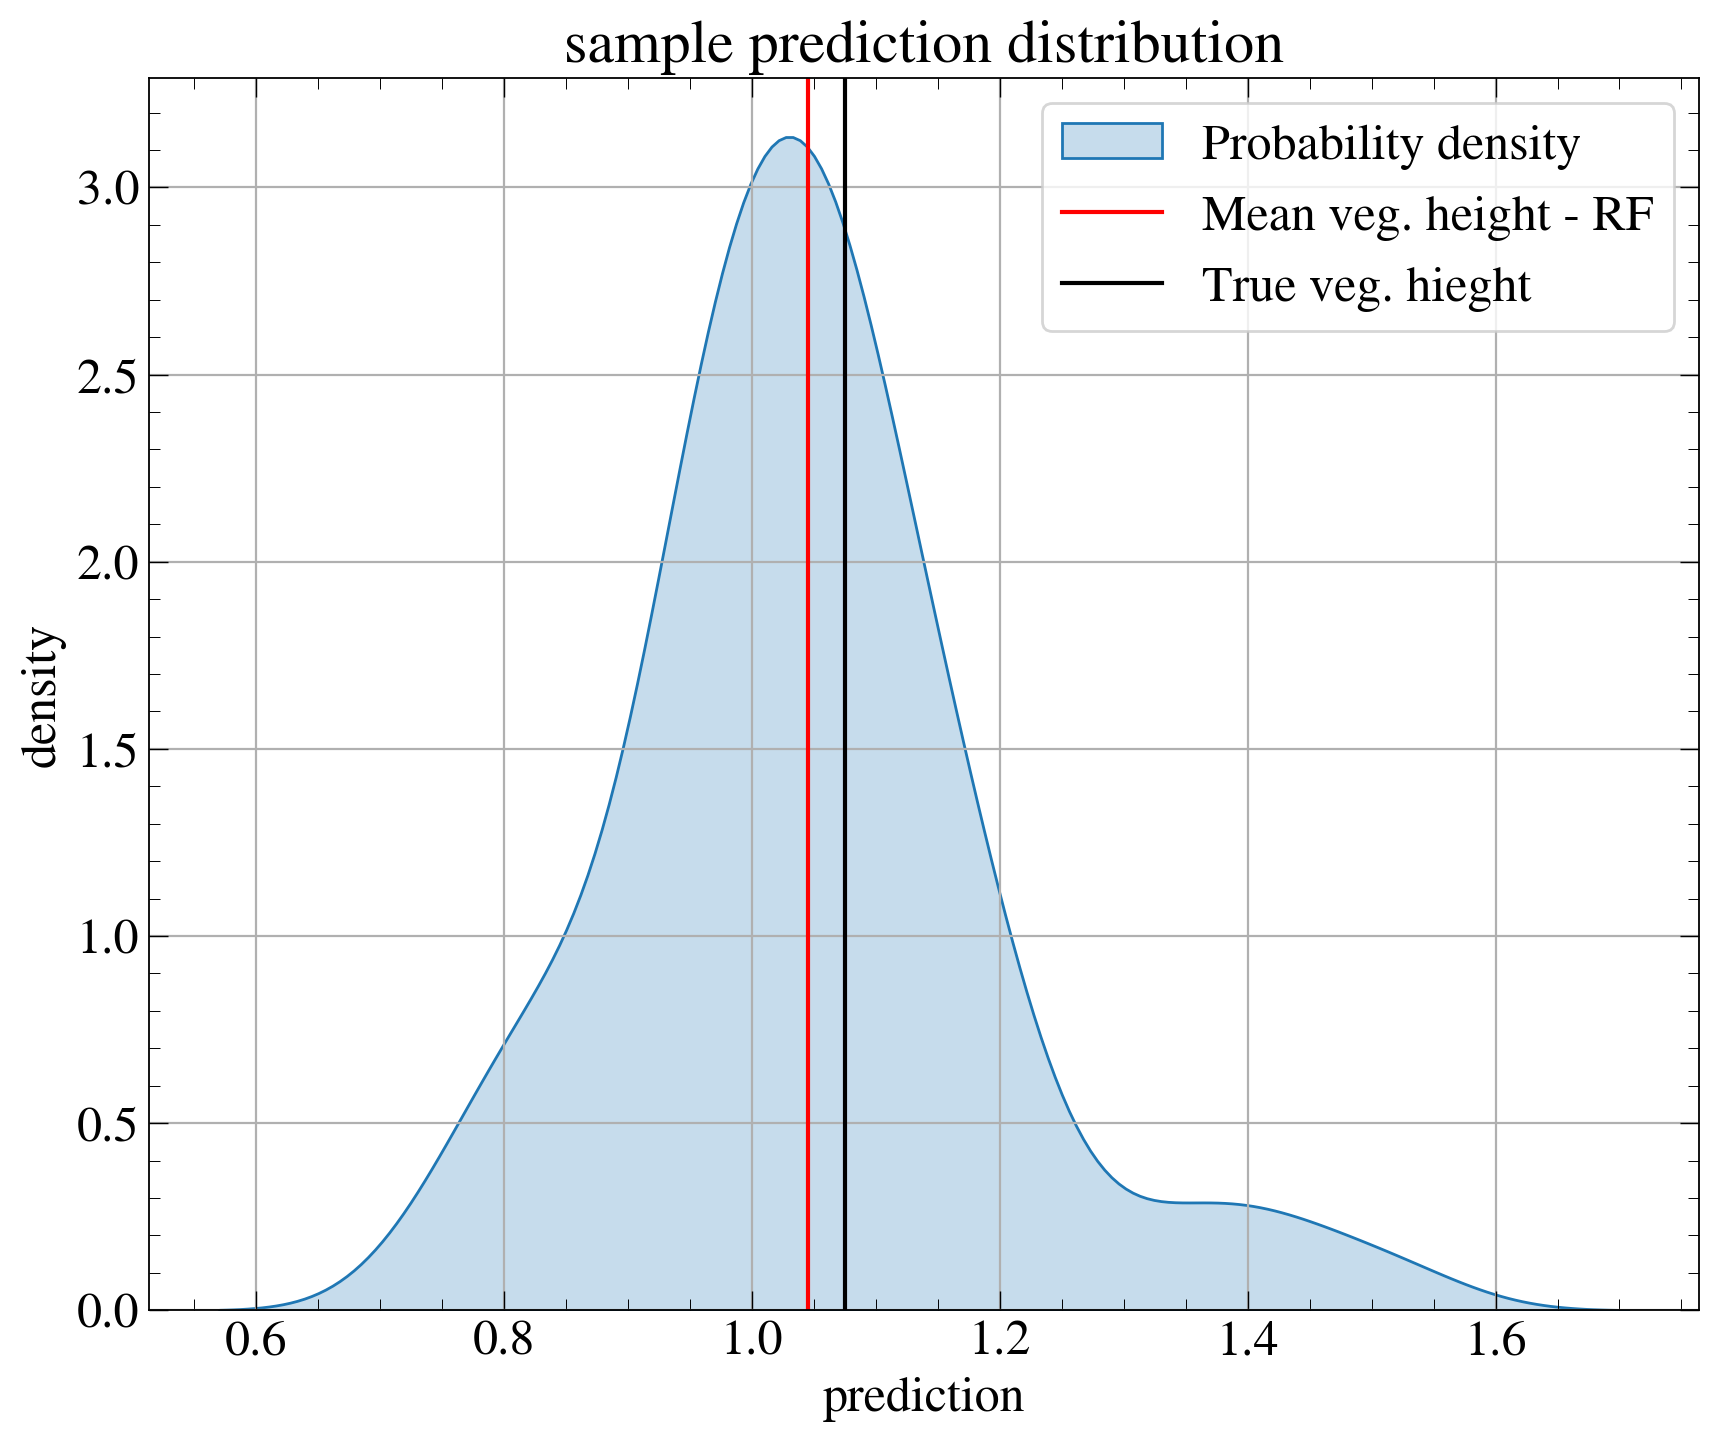

In [10]:
plt.figure(figsize=(10,8))
n = 0
sns.kdeplot(all_tree_preds_rf[:, n].reshape(-1, 1).flatten(), shade=True, label = "Probability density")
plt.axvline(y_pred_mean_rf[n], color='red', label = "Mean veg. height - RF")
plt.axvline(y_test_copy[n], color="black", label = "True veg. hieght")
plt.xlabel("prediction")
plt.ylabel("density")
plt.title("sample prediction distribution")
plt.legend()
plt.show()

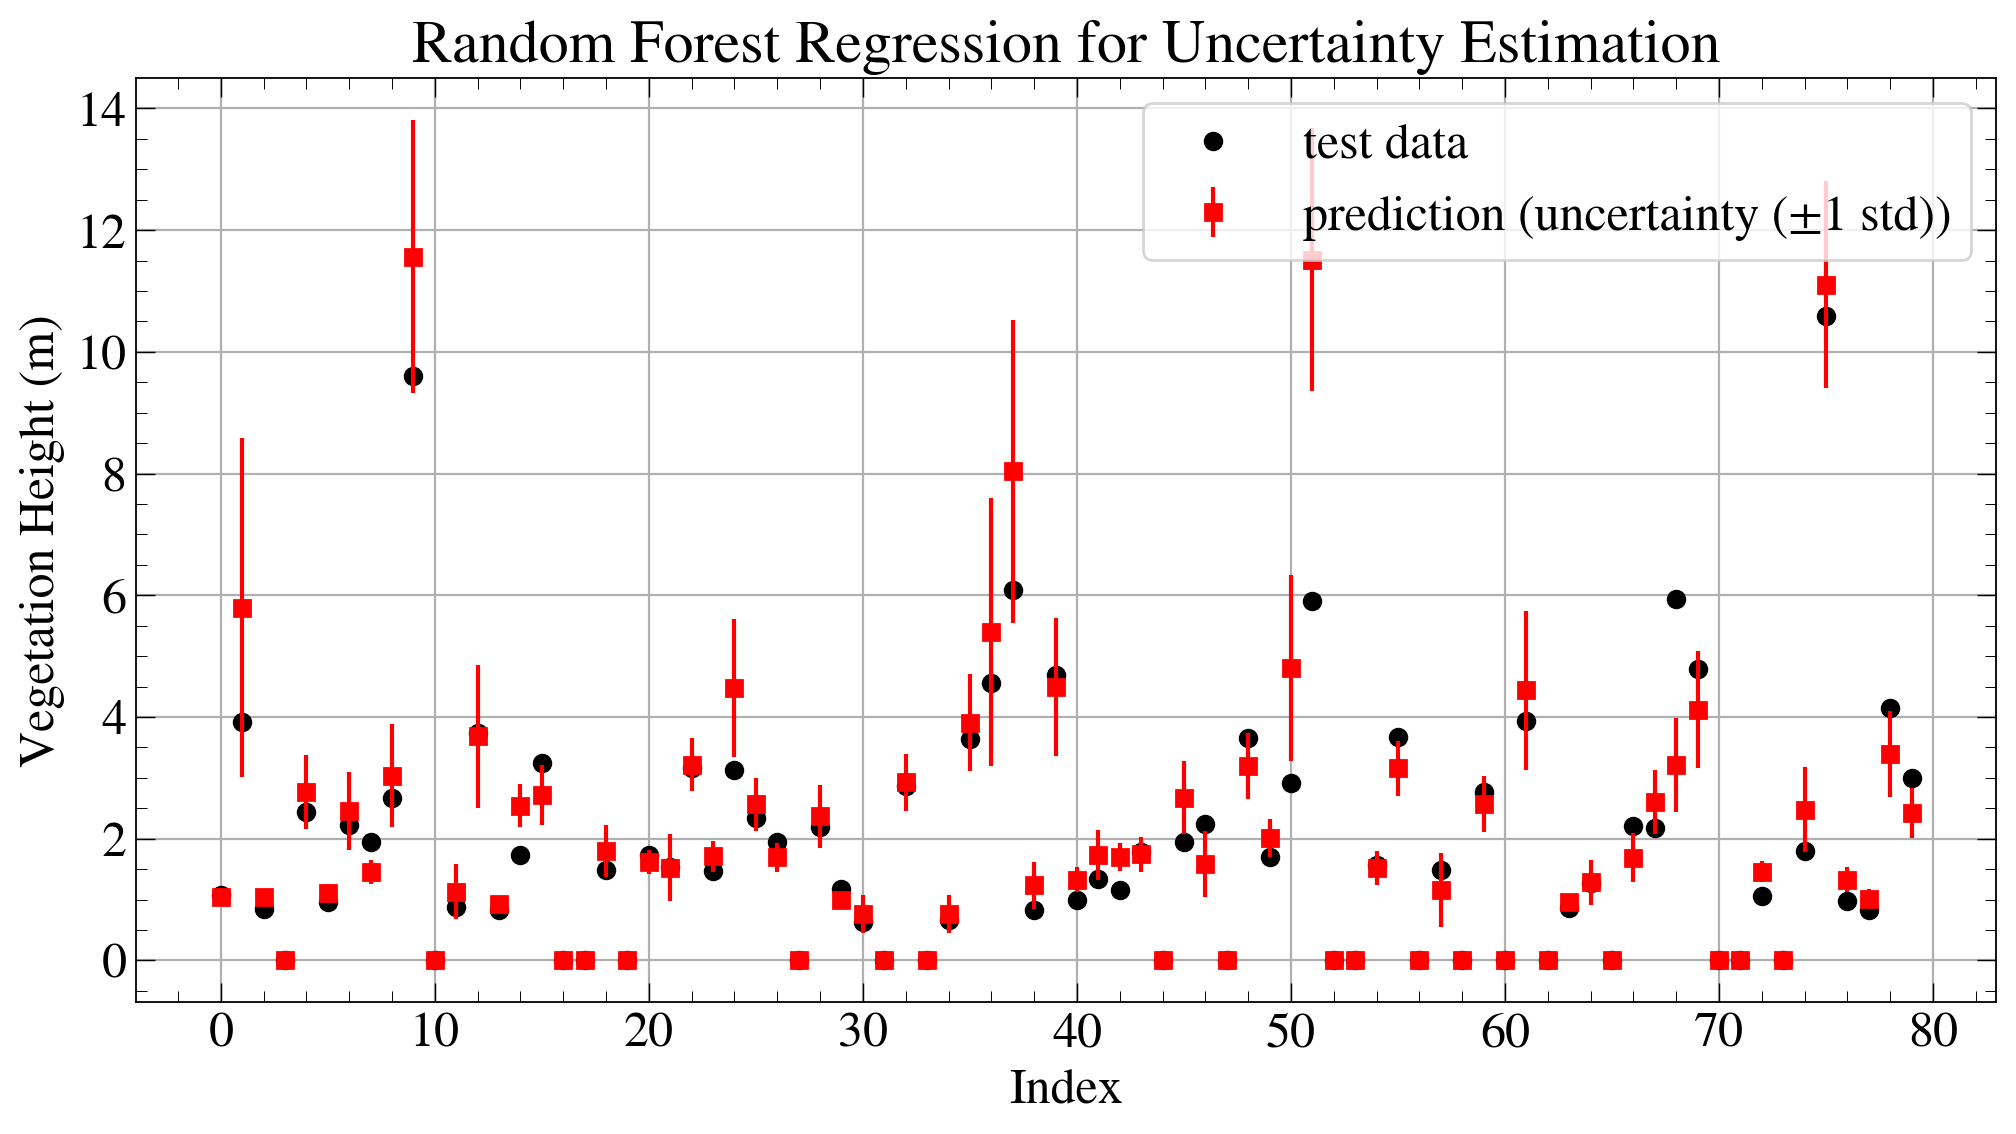

In [11]:
plt.figure(figsize=(12,6))
k = 80
plt.plot(y_test_copy[:k], color="black", label="test data", marker = "o", linestyle="None")
plt.errorbar(list(range(k)), 
             y_pred_mean_rf[:k], 
             yerr = y_pred_std_rf[:k], 
             color="red", alpha=1.0, 
             label="prediction (uncertainty (±1 std))", 
             linestyle="None", fmt='s')

plt.xlabel("Index")
plt.ylabel("Vegetation Height (m)")
plt.legend()
plt.title("Random Forest Regression for Uncertainty Estimation")
plt.show()

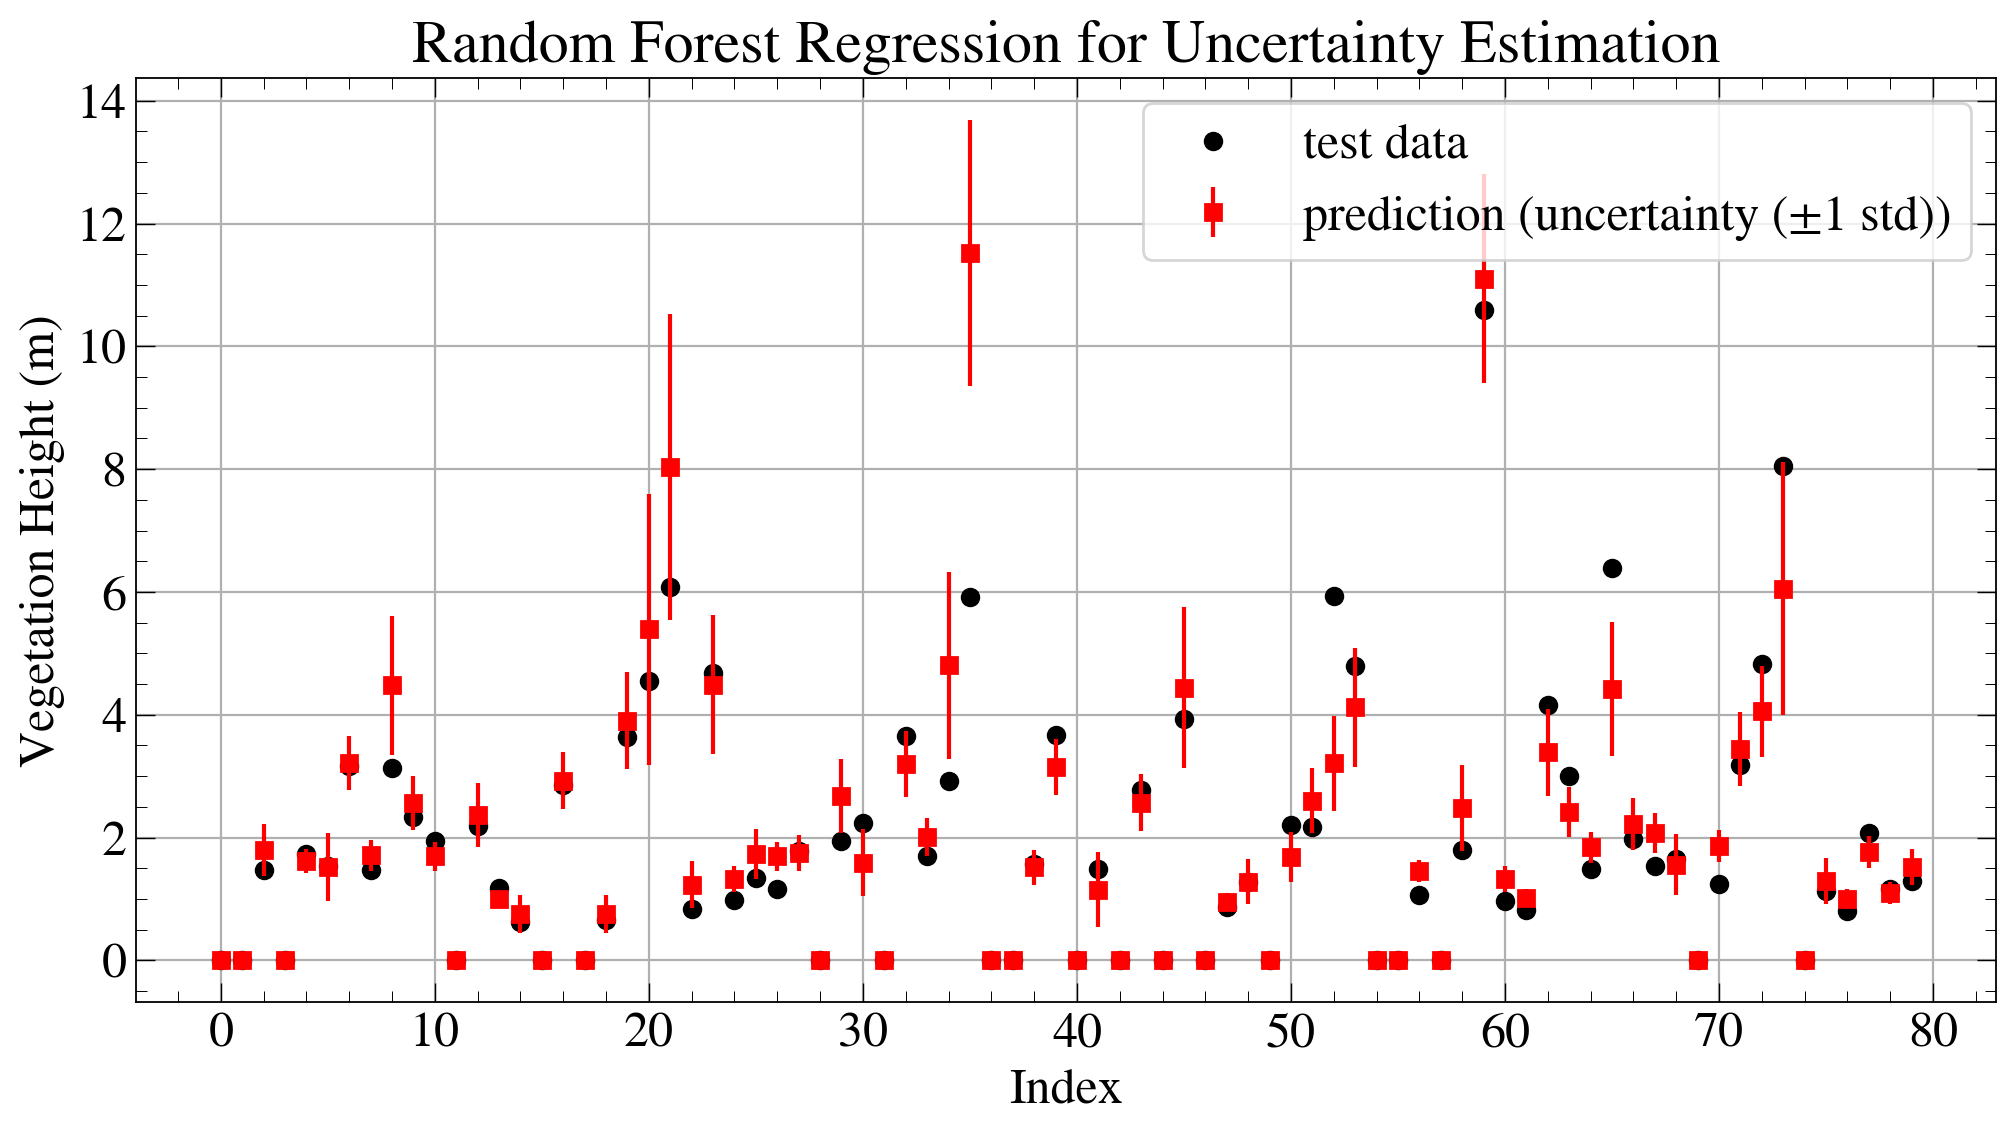

In [12]:
plt.figure(figsize=(12,6))
k = 80
plt.plot(y_test_copy[-k:], color="black", label="test data", marker = "o", linestyle="None")
plt.errorbar(list(range(k)), 
             y_pred_mean_rf[-k:], 
             yerr = y_pred_std_rf[-k:], 
             color="red", alpha=1.0, 
             label="prediction (uncertainty (±1 std))", 
             linestyle="None", fmt='s')

plt.xlabel("Index")
plt.ylabel("Vegetation Height (m)")
plt.legend()
plt.title("Random Forest Regression for Uncertainty Estimation")
plt.show()

### Scatter Plots

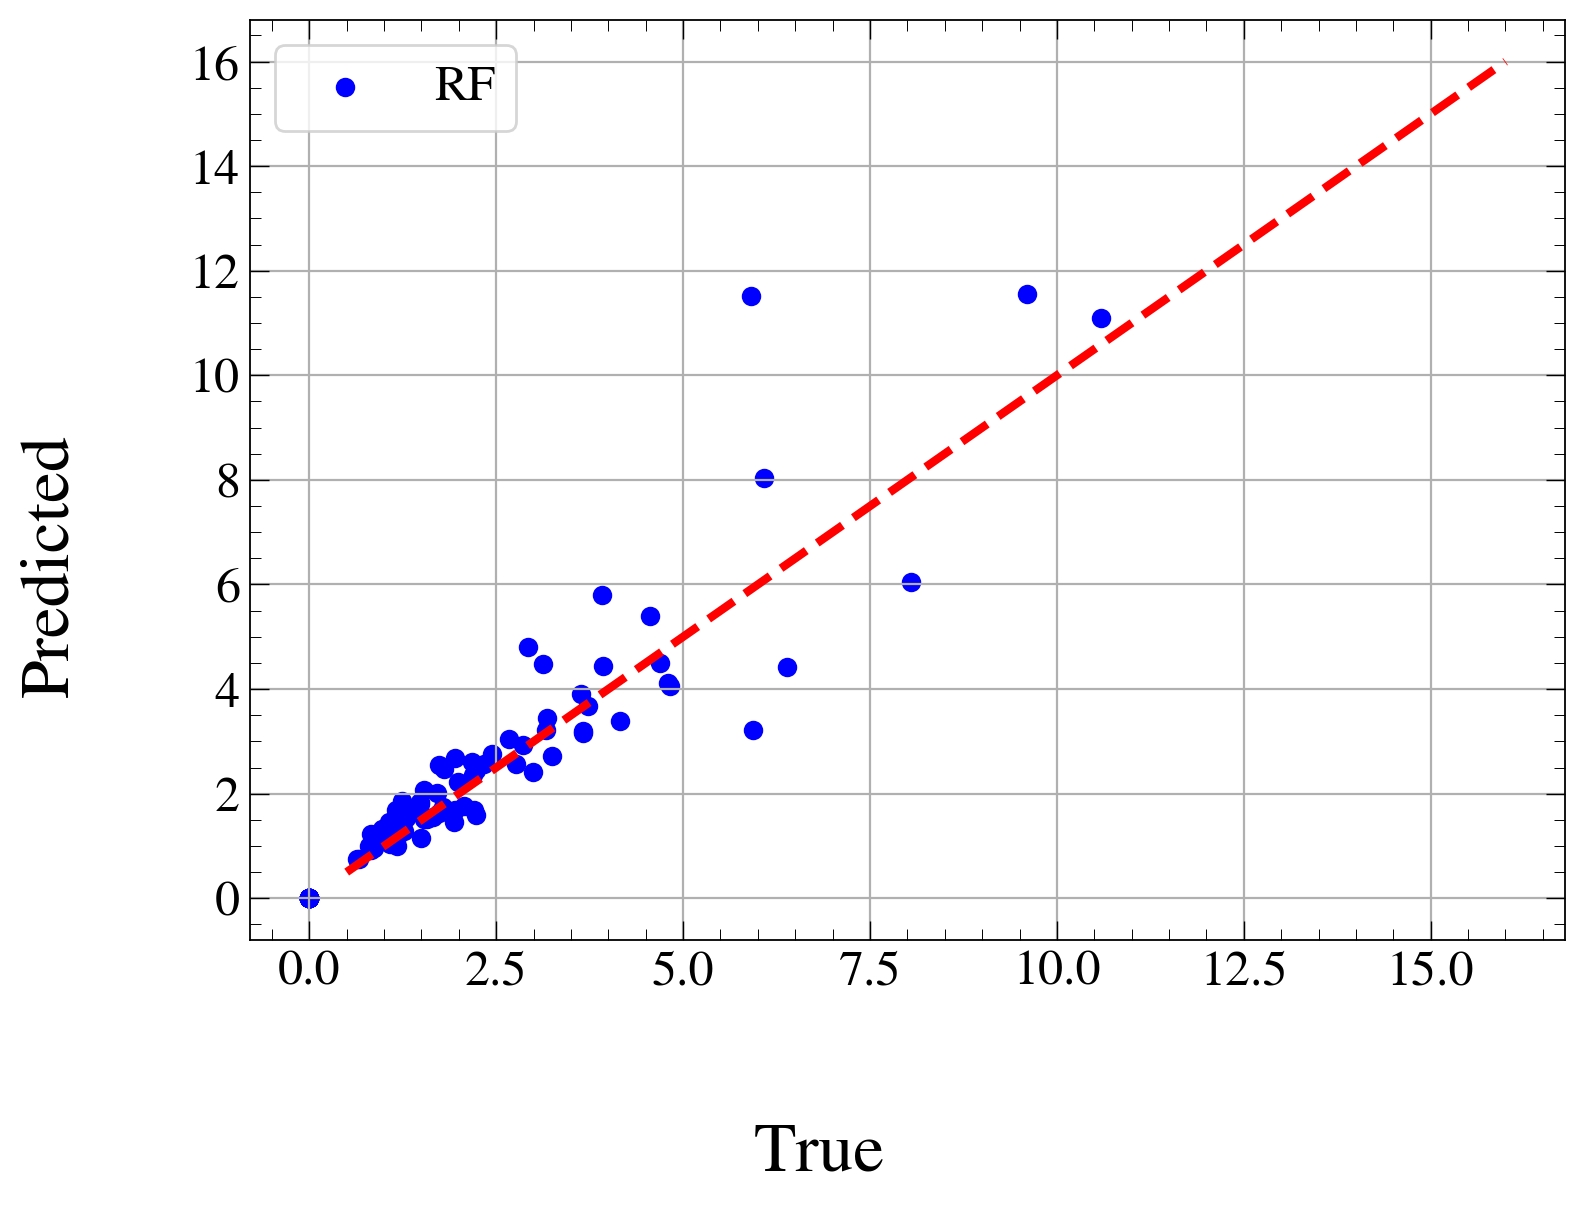

In [13]:
xx = np.linspace(0.5, 16)

# Create figure and subplots with shared y-axis
fig, axs = plt.subplots(figsize=(8, 6))

axs.scatter(y_test_copy, y_pred_mean_rf, color="blue", label = "RF")
axs.plot(xx, xx, color="red", linestyle="--", linewidth = 3)
# axs.set_title("True vs Predicted RF")
axs.legend()

#########################
# Super labels
fig.supxlabel(r"True", va="center", ha="center", fontsize=25)
fig.supylabel(r"Predicted", va="center", ha="center", fontsize=25)
# plt.suptitle("True vs Predicted", fontsize=18)

# Adjust layout
plt.tight_layout(h_pad=-1.0, w_pad=-0.7)
plt.show()

### Correlation Plot

Text(0.5, 1.0, 'RF')

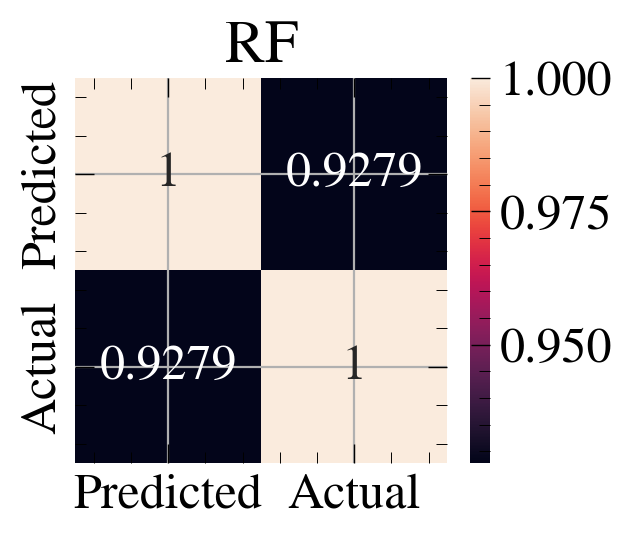

In [14]:
#-------------Correlation plot (MCD)
plt.figure(figsize = (3.0, 2.5))

#########################
#-------------Correlation plot (RF)
cor_rf = pd.DataFrame(y_pred_mean_rf).rename(columns = {0:"Predicted"})\
.join(pd.DataFrame(y_test_copy, columns = ['Actual']))

corrMatrix_rf = cor_rf.corr()
sns.heatmap(corrMatrix_rf, annot=True, fmt=".4g")
plt.title("RF")

### Predicition Errors

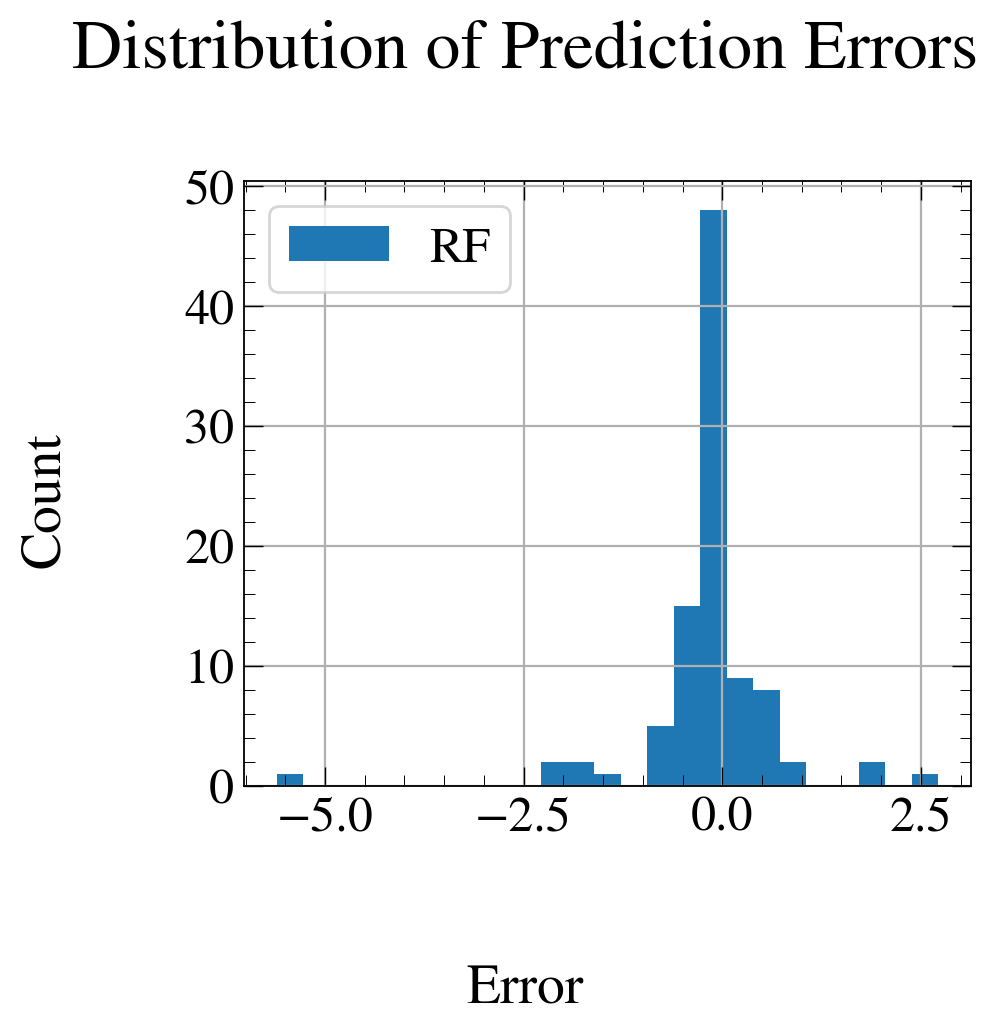

In [15]:
# Create subplots with shared y-axis
fig, axs = plt.subplots(figsize=(5, 5))

#########################
# Histogram of errors (RF)
error_rf = y_test_copy - y_pred_mean_rf
axs.hist(error_rf, bins=25, label = "RF")
# axs.set_title("Prediction Errors (RF)")
axs.legend()

# Super labels
fig.supxlabel(r"Error", va="center", ha="center", fontsize=20)
fig.supylabel(r"Count", va="center", ha="center", fontsize=20)
# Add a super title for the entire figure
plt.suptitle("Distribution of Prediction Errors", fontsize=25)

# Adjust layout
plt.tight_layout(h_pad = 0.0, w_pad = -0.6)
plt.show()


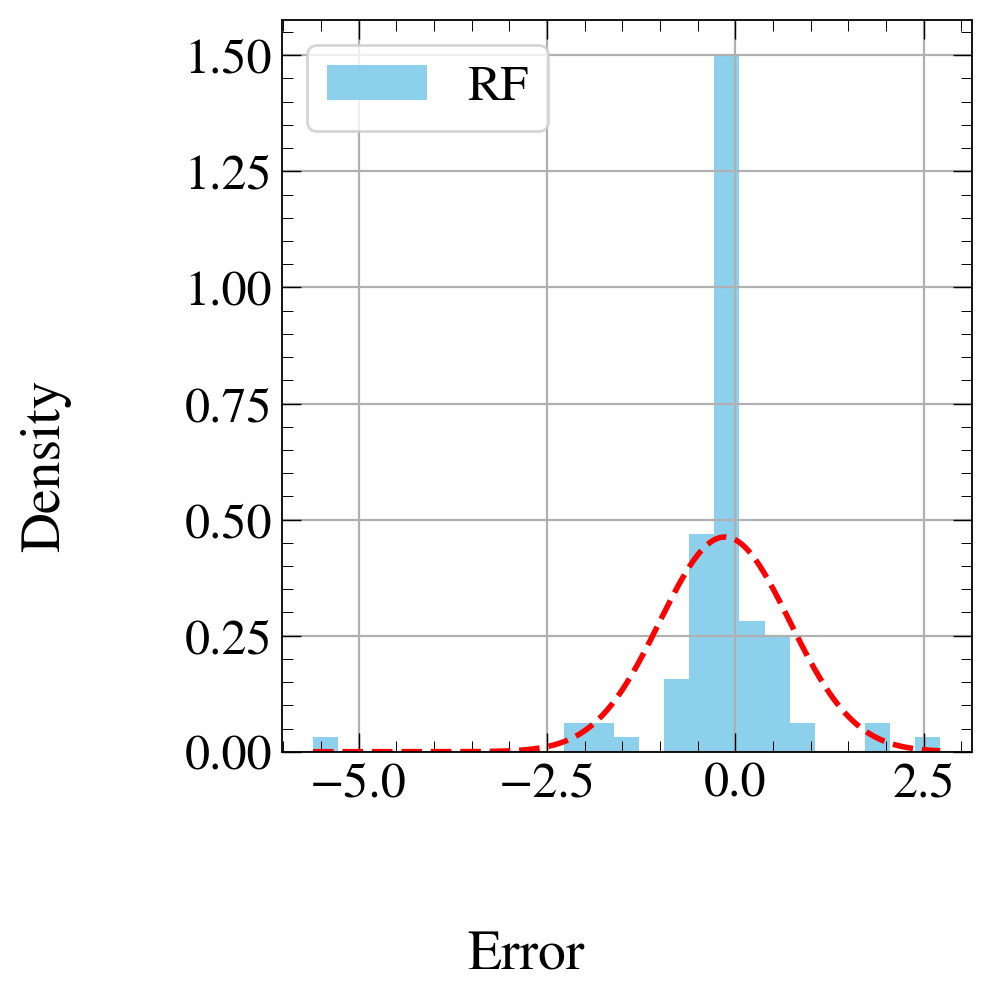

In [16]:
# Create subplots with shared y-axis
fig, axs = plt.subplots(figsize=(5, 5))

#########################
# Histogram + Density (RF)
error_rf = y_test_copy - y_pred_mean_rf
mu_rf, std_rf = np.mean(error_rf), np.std(error_rf)
x_rf = np.linspace(min(error_rf), max(error_rf), 200)
axs.hist(error_rf, bins=25, density=True, alpha=0.95, color="skyblue", label="RF")
axs.plot(x_rf, norm.pdf(x_rf, mu_rf, std_rf), "r--", linewidth=2)
# axs.set_title("Prediction Errors (RF)")
axs.legend()

# Super labels
fig.supxlabel("Error", va="center", ha="center", fontsize=20)
fig.supylabel("Density", va="center", ha="center", fontsize=20)
# plt.suptitle("Distribution of Prediction Errors with Normal Density", fontsize=25)

# Adjust layout
plt.tight_layout(h_pad=0.0, w_pad=-0.6)
plt.show()

### Compute R-Squared ($R^2$) and Compute Root Mean Square Error (RMSE) 

In [17]:
r2_rf = r2_score(y_test_copy, y_pred_mean_rf)
display(Math(f"R^2(RF) = {r2_rf}"))

rmse_rf = np.sqrt(mean_squared_error(y_test_copy, y_pred_mean_rf))
print("RMSE RF:", rmse_rf)

<IPython.core.display.Math object>

RMSE RF: 0.8737703256734008


### Variable Importance

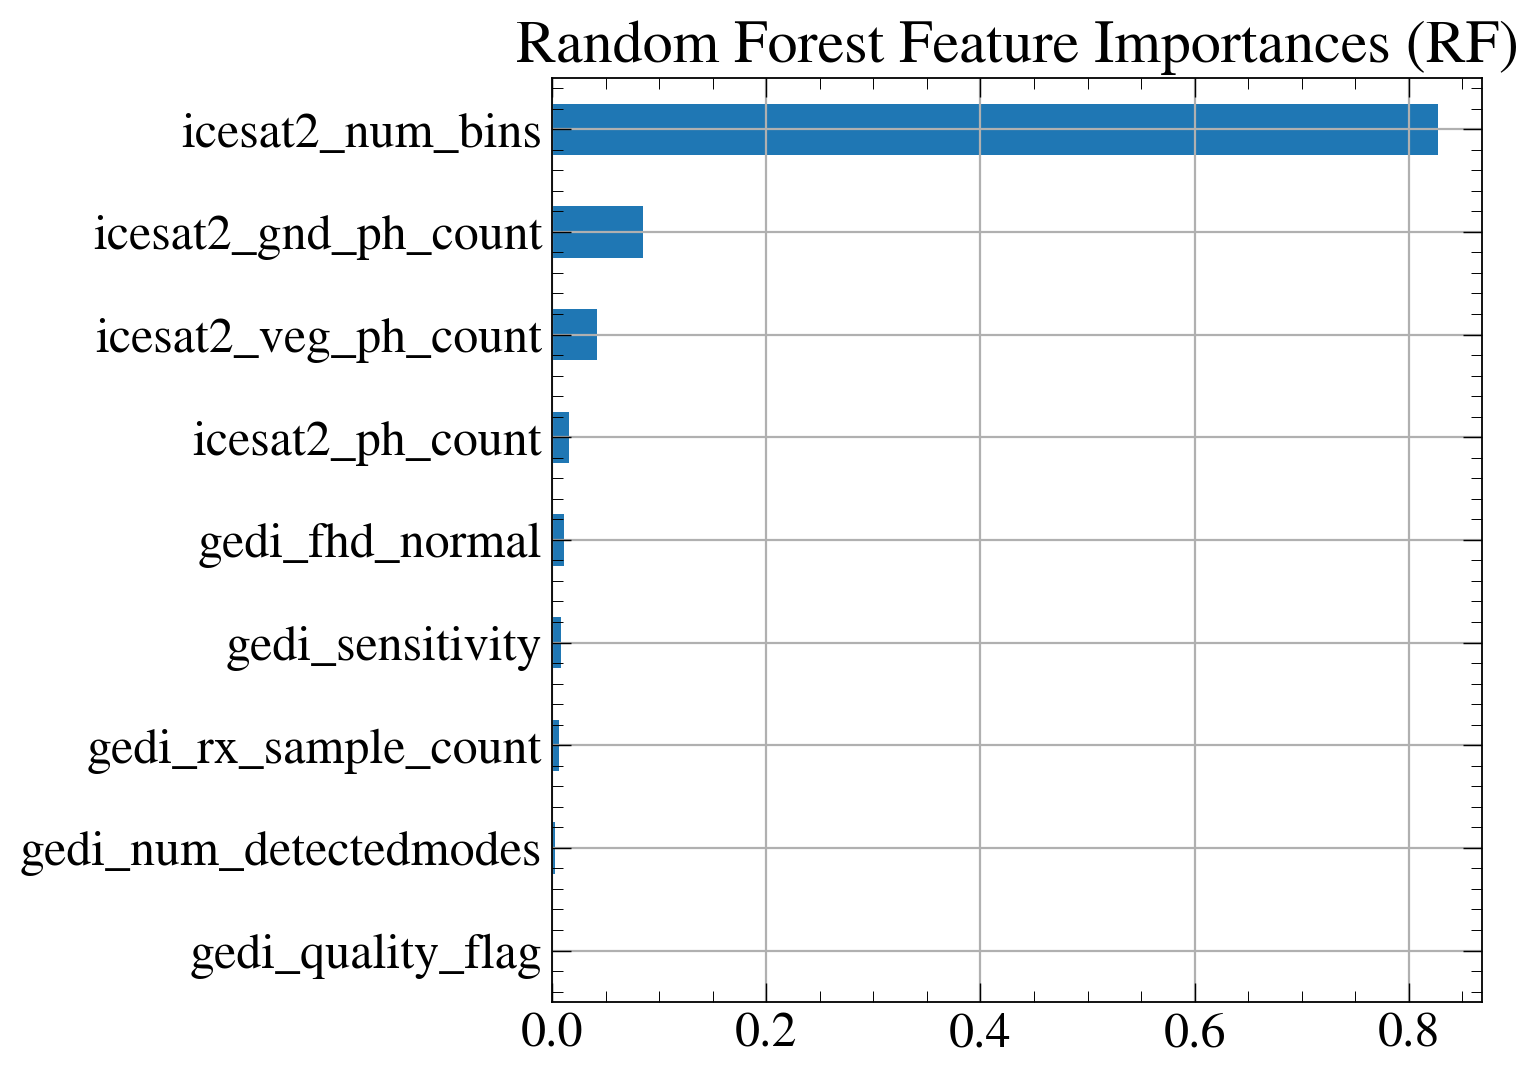

In [18]:
importances = rf_model.feature_importances_
new_cols = np.array(use_cols[:-2])  

# Plot
# pd.Series(importances).sort_values().plot(kind='barh')
pd.Series(importances, index=new_cols).sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importances (RF)")
plt.show()

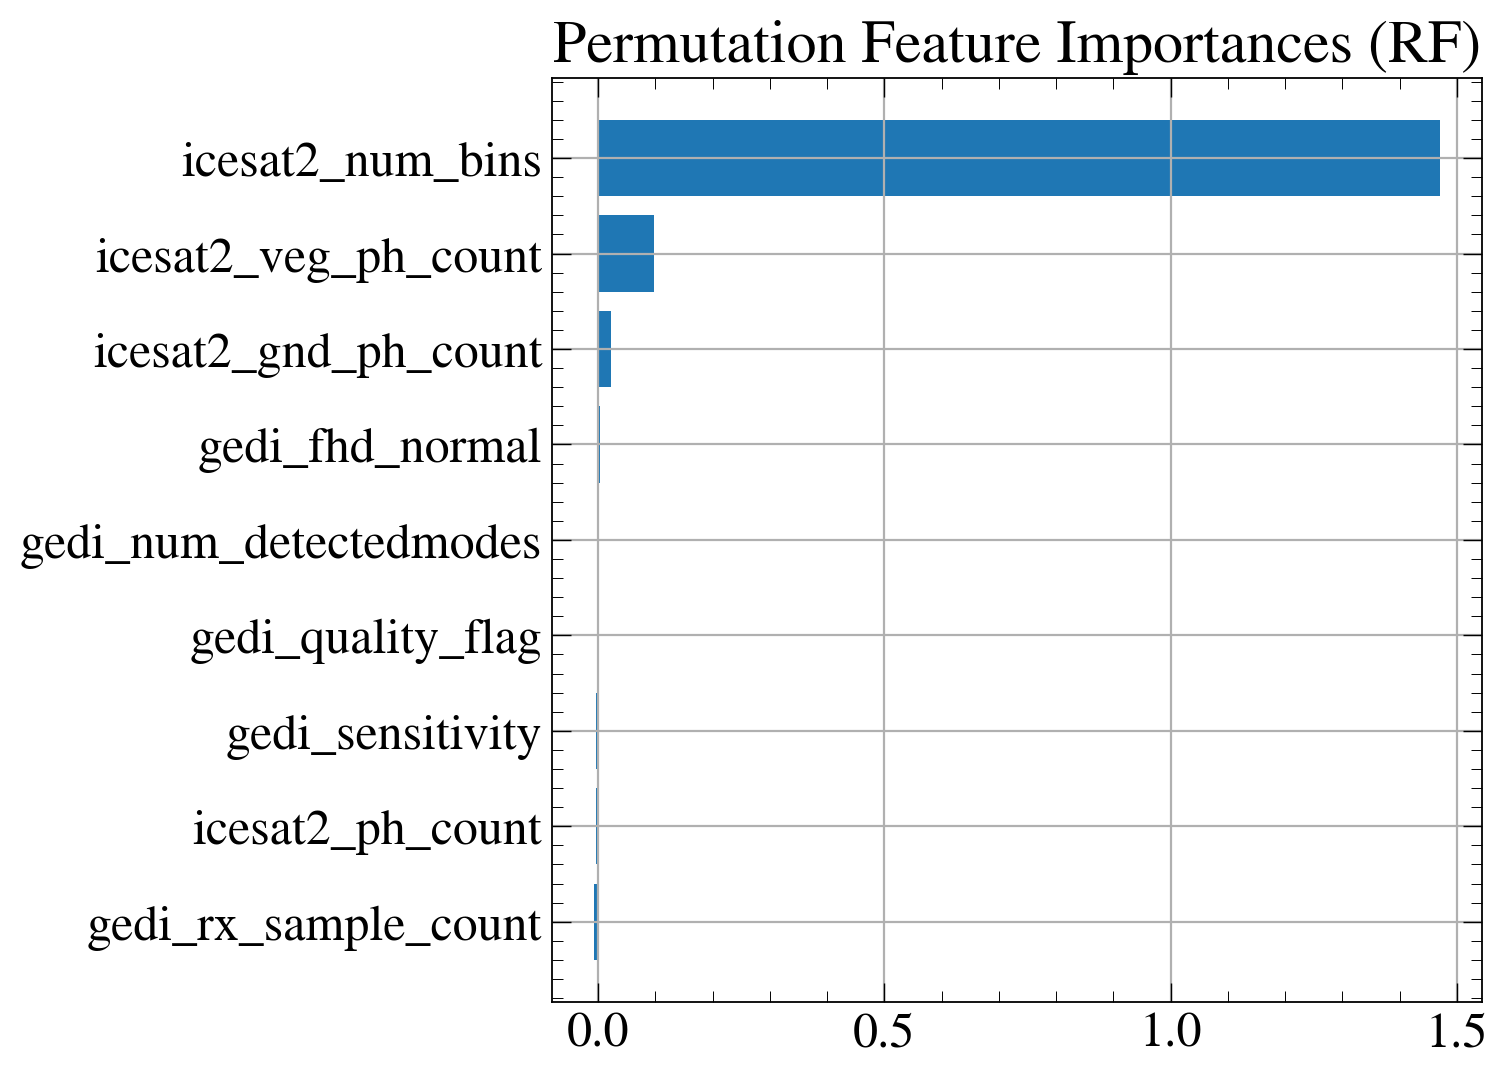

In [19]:
result = permutation_importance(rf_model, X_test_copy, y_test_copy, n_repeats=30, random_state=42, scoring='r2')
sorted_idx = result.importances_mean.argsort()

plt.barh(new_cols[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importances (RF)")
plt.show()

## Random Forest (RF) Model - GEDI
### Train-Test Split

In [20]:
# Separate features and target
# X = coregistered_data_ml.drop(target_cols, axis = 1) # Predictor variables
y = coregistered_data_ml[target_cols[1]].values # Target variable

# Build a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features),
    ]
)

# Split data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
# Keep copies of the test data for future use
X_test_copy = X_test_0.values
y_test_copy = y_test_0

# Standardize the features (X)
X_train_scaled = preprocessor.fit_transform(X_train_0)
X_test_scaled = preprocessor.transform(X_test_0)

# Standardize the target if needed
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_0.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_0.reshape(-1, 1))

# Convert the standardized data to PyTorch tensors
X_train_tensor_0 = torch.from_numpy(X_train_scaled.toarray() if hasattr(X_train_scaled, "toarray") else X_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled.toarray() if hasattr(X_test_scaled, "toarray") else X_test_scaled).float()

y_train_tensor_0 = torch.from_numpy(y_train_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float()

# Check the shapes of the tensors
print(f"X_train shape: {X_train_tensor_0.shape}")
print(f"y_train shape: {y_train_tensor_0.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"y_test shape: {y_test_tensor.shape}")

X_train shape: torch.Size([381, 10])
y_train shape: torch.Size([381, 1])
X_test shape: torch.Size([96, 10])
y_test shape: torch.Size([96, 1])


In [ ]:
# Define the model (RandomForestRegressor)
rf_model = RandomForestRegressor(n_estimators=100,  # Number of trees in the forest 
                                 max_depth=5,       # Maximum depth of each tree 
                                 random_state=42,   # Setting seed
                                 bootstrap=True     # Bootstrapping for randomness
)

# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store the average losses for each fold
train_losses = []
val_losses = []

# Perform KFold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_0)):
    print(f"Training Fold {fold+1}")
    # Create train and validation subsets using the indices
    X_train, X_val = X_train_0.values[train_idx], X_train_0.values[val_idx]
    y_train, y_val = y_train_0[train_idx], y_train_0[val_idx]

    # Train the model on the training data
    rf_model.fit(X_train, y_train.ravel())  # .ravel() to convert y to a 1D array

    # Predict on the training and validation data
    y_train_pred = rf_model.predict(X_train)
    y_val_pred = rf_model.predict(X_val)

    # Calculate MSE for both training and validation
    train_loss = mean_squared_error(y_train, y_train_pred)
    val_loss = mean_squared_error(y_val, y_val_pred)

    # Store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Fold {fold+1} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Final average losses across all folds
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)

print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")

In [22]:
# Get predictions from all individual trees
all_tree_preds_rf = np.stack([tree.predict(X_test_copy) for tree in rf_model.estimators_])

# Compute mean and std across all trees
y_pred_mean_rf = []
y_pred_std_rf = []
# Compute mean and standard deviation of the inverse predictions to get the actual predictions and standard deviations
for i in range(all_tree_preds_rf.shape[1]):
    pred_avg_rf = np.mean(all_tree_preds_rf[:,i].reshape(-1, 1))
    y_pred_mean_rf.append(float(pred_avg_rf))    
    
    pred_sd_rf = np.std(all_tree_preds_rf[:,i].reshape(-1, 1))
    y_pred_std_rf.append(float(pred_sd_rf))
    
display(np.array(y_pred_mean_rf))
display(np.array(y_pred_std_rf))
# y_test_copy

array([1.73850345, 2.16048255, 2.21755287, 1.13549667, 3.14119325,
       1.54174829, 3.20225288, 1.38802962, 1.53880784, 1.51515859,
       3.42657871, 1.0824576 , 1.86114941, 1.09137061, 1.49019346,
       5.52216429, 1.08380849, 1.08345798, 1.76218231, 1.0825473 ,
       1.30842878, 2.07775796, 2.98634328, 1.70857452, 1.47355182,
       1.99342807, 1.51927854, 1.08380849, 1.0911102 , 1.10591509,
       1.08729903, 4.03567334, 2.90320938, 1.08837801, 1.0875616 ,
       1.60734224, 3.50352598, 1.06966285, 1.39991876, 7.30462179,
       2.0339194 , 1.68149493, 1.79612327, 1.40026743, 1.55982116,
       1.08491006, 3.71357043, 1.09900285, 4.72035943, 2.08836978,
       1.80385265, 2.05816854, 1.65141678, 1.45668858, 2.42395716,
       3.02639842, 1.08227539, 1.10457248, 1.35490323, 1.7418963 ,
       1.08530002, 2.40280921, 1.08617919, 1.4530771 , 1.09244959,
       3.93068425, 1.08608655, 2.18910007, 9.38159171, 3.51460014,
       1.1005009 , 1.86427104, 2.18953921, 2.42070219, 2.91593

array([0.24327062, 0.32072623, 0.53723538, 0.11051147, 1.26517766,
       0.13791758, 0.5159633 , 0.10434806, 0.19402765, 0.17776146,
       0.54393077, 0.03396439, 0.21640921, 0.04561513, 0.14426459,
       2.40747911, 0.03396585, 0.03372269, 0.14361752, 0.02965367,
       0.23231991, 0.47143961, 0.59407677, 0.18125982, 0.11733537,
       0.16088059, 0.17472381, 0.03396585, 0.05132538, 0.06235453,
       0.03451817, 0.90393403, 0.63864392, 0.03517882, 0.04533101,
       0.1491057 , 0.46728104, 0.10592209, 0.09862148, 1.75374451,
       0.28023434, 0.35285675, 0.18322615, 0.39399872, 0.16219056,
       0.05024772, 1.19631479, 0.05592205, 2.20716962, 0.34855184,
       0.15606706, 0.28149931, 0.3176161 , 0.12004623, 0.37162465,
       0.58759742, 0.03057857, 0.05977   , 0.31908707, 0.16839176,
       0.04256848, 0.46603416, 0.0372931 , 0.1435546 , 0.04602173,
       1.89276368, 0.04915416, 0.34200591, 2.73244507, 0.57694164,
       0.05282727, 0.4152052 , 0.36527941, 0.63786818, 0.77211

### Actual vs Predicted Plot

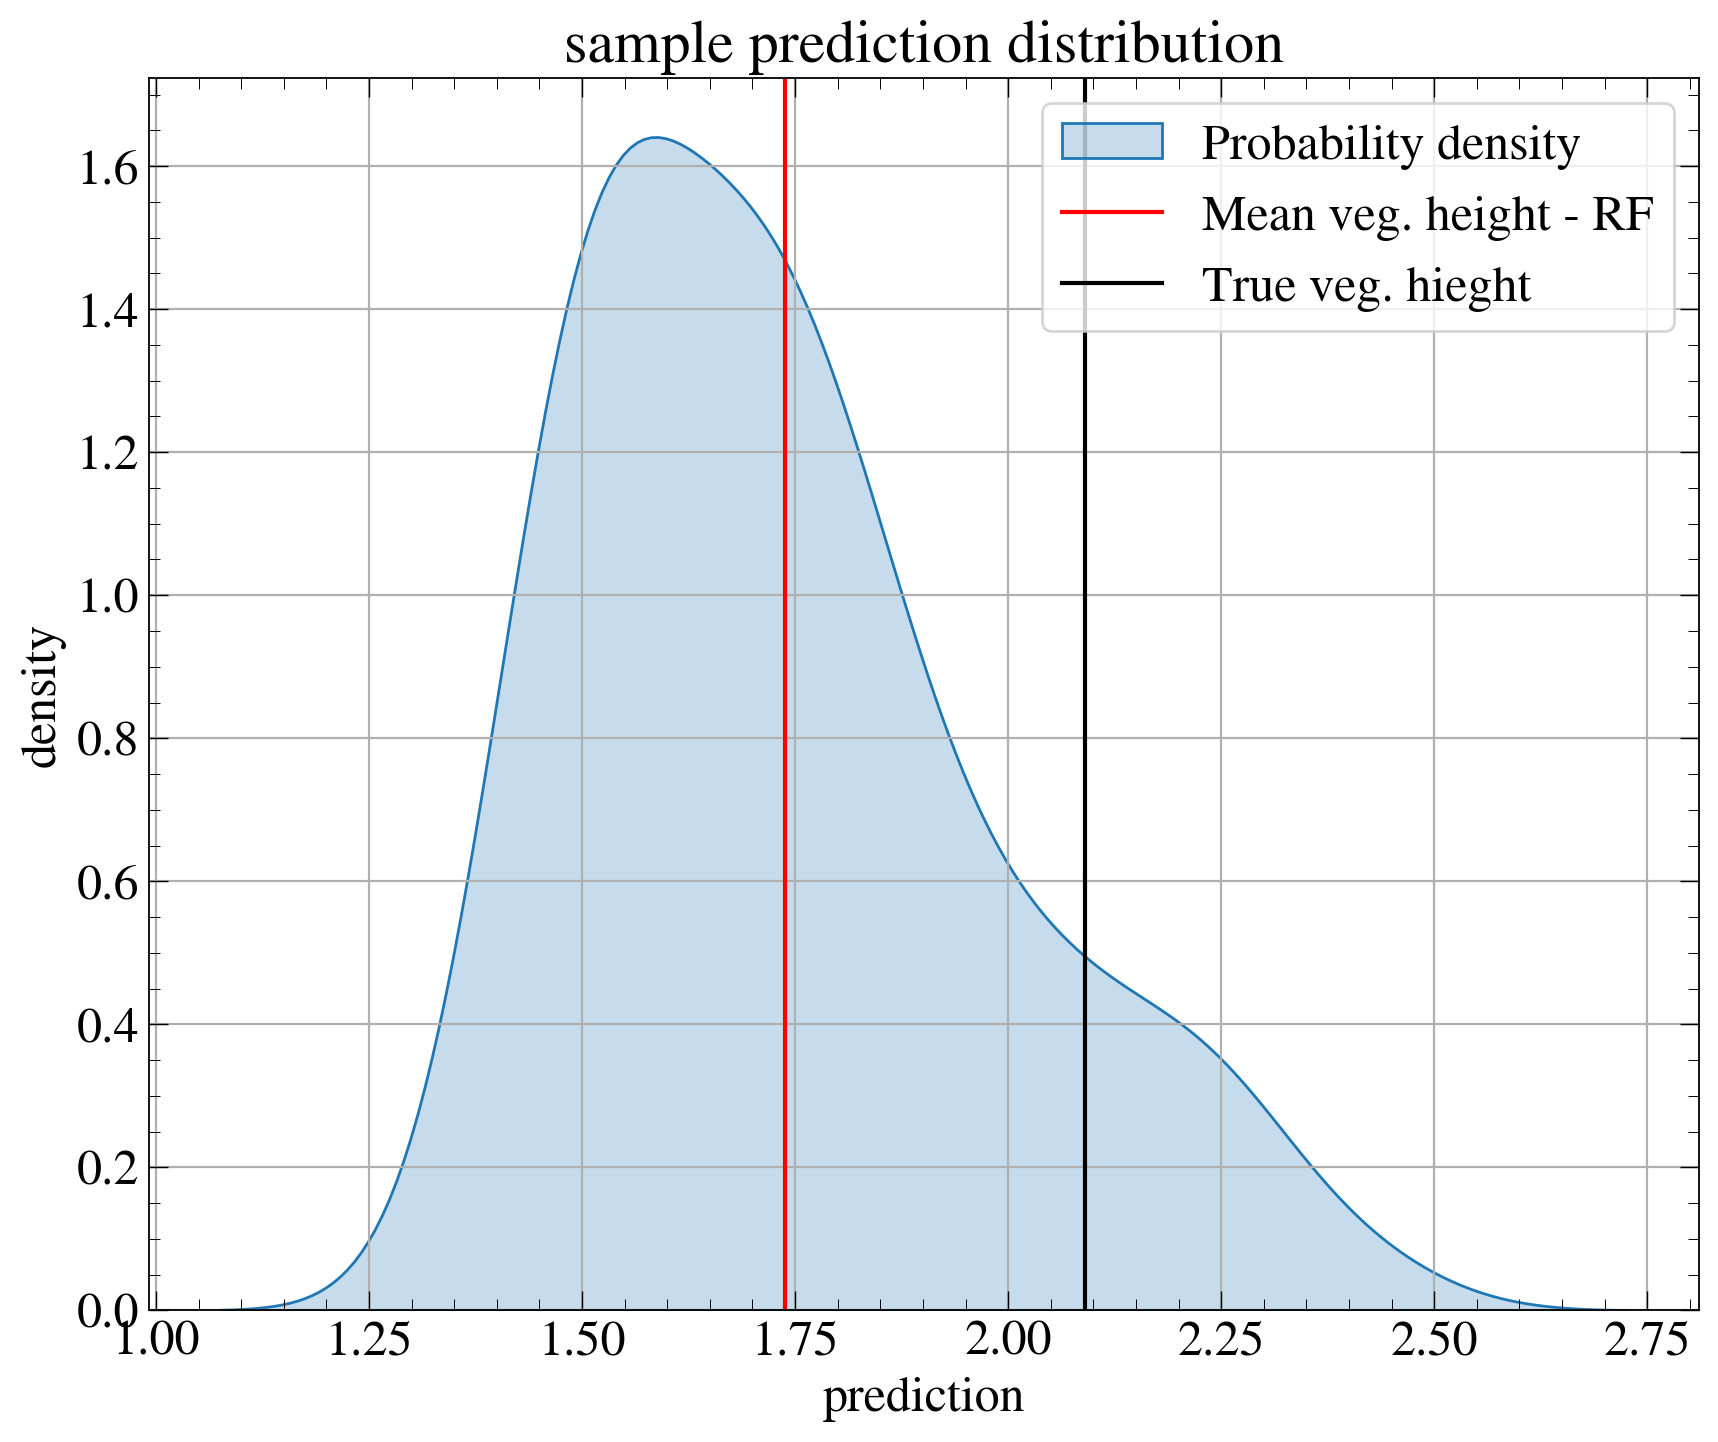

In [23]:
plt.figure(figsize=(10,8))
n = 0
sns.kdeplot(all_tree_preds_rf[:, n].reshape(-1, 1).flatten(), shade=True, label = "Probability density")
plt.axvline(y_pred_mean_rf[n], color='red', label = "Mean veg. height - RF")
plt.axvline(y_test_copy[n], color="black", label = "True veg. hieght")
plt.xlabel("prediction")
plt.ylabel("density")
plt.title("sample prediction distribution")
plt.legend()
plt.show()

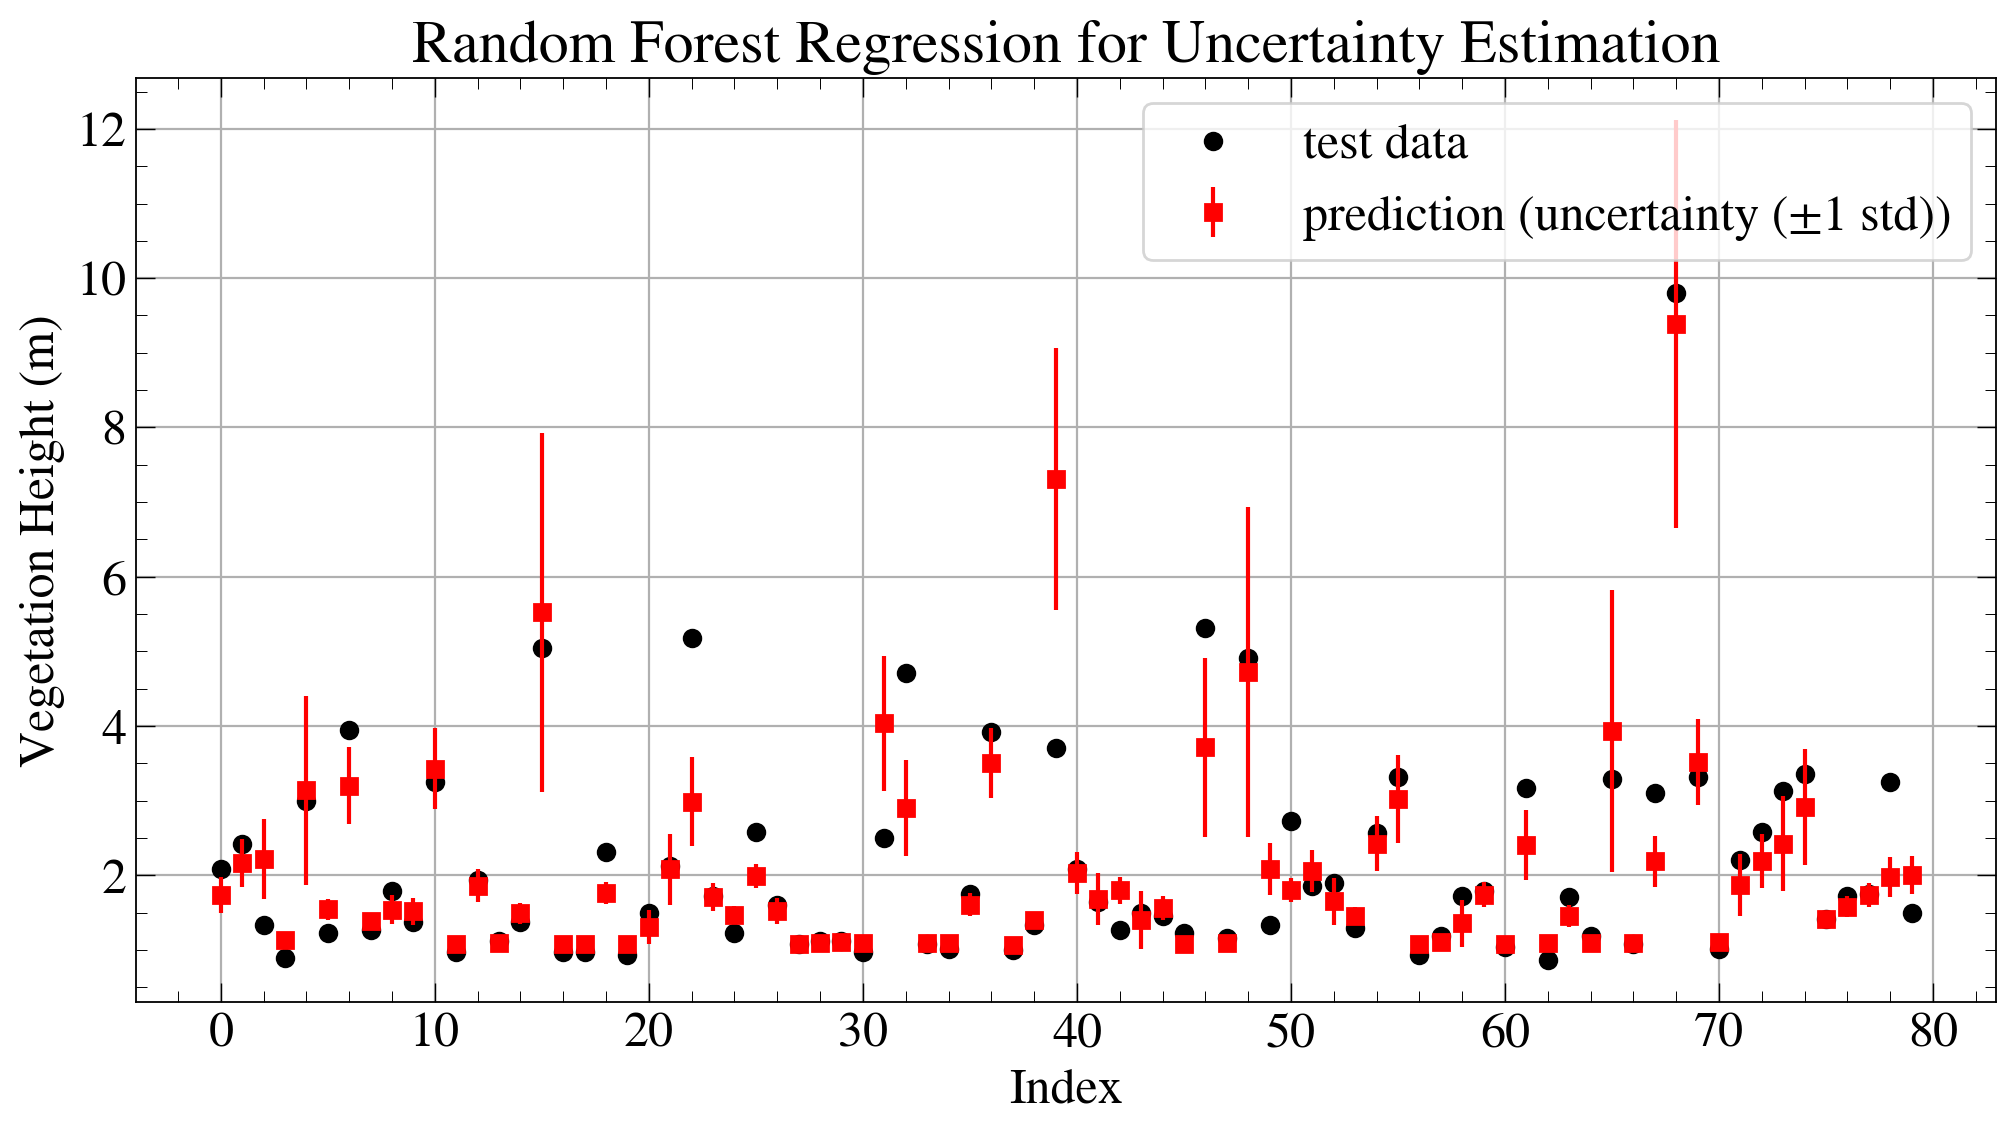

In [24]:
plt.figure(figsize=(12,6))
k = 80
plt.plot(y_test_copy[:k], color="black", label="test data", marker = "o", linestyle="None")
plt.errorbar(list(range(k)), 
             y_pred_mean_rf[:k], 
             yerr = y_pred_std_rf[:k], 
             color="red", alpha=1.0, 
             label="prediction (uncertainty (±1 std))", 
             linestyle="None", fmt='s')

plt.xlabel("Index")
plt.ylabel("Vegetation Height (m)")
plt.legend()
plt.title("Random Forest Regression for Uncertainty Estimation")
plt.show()

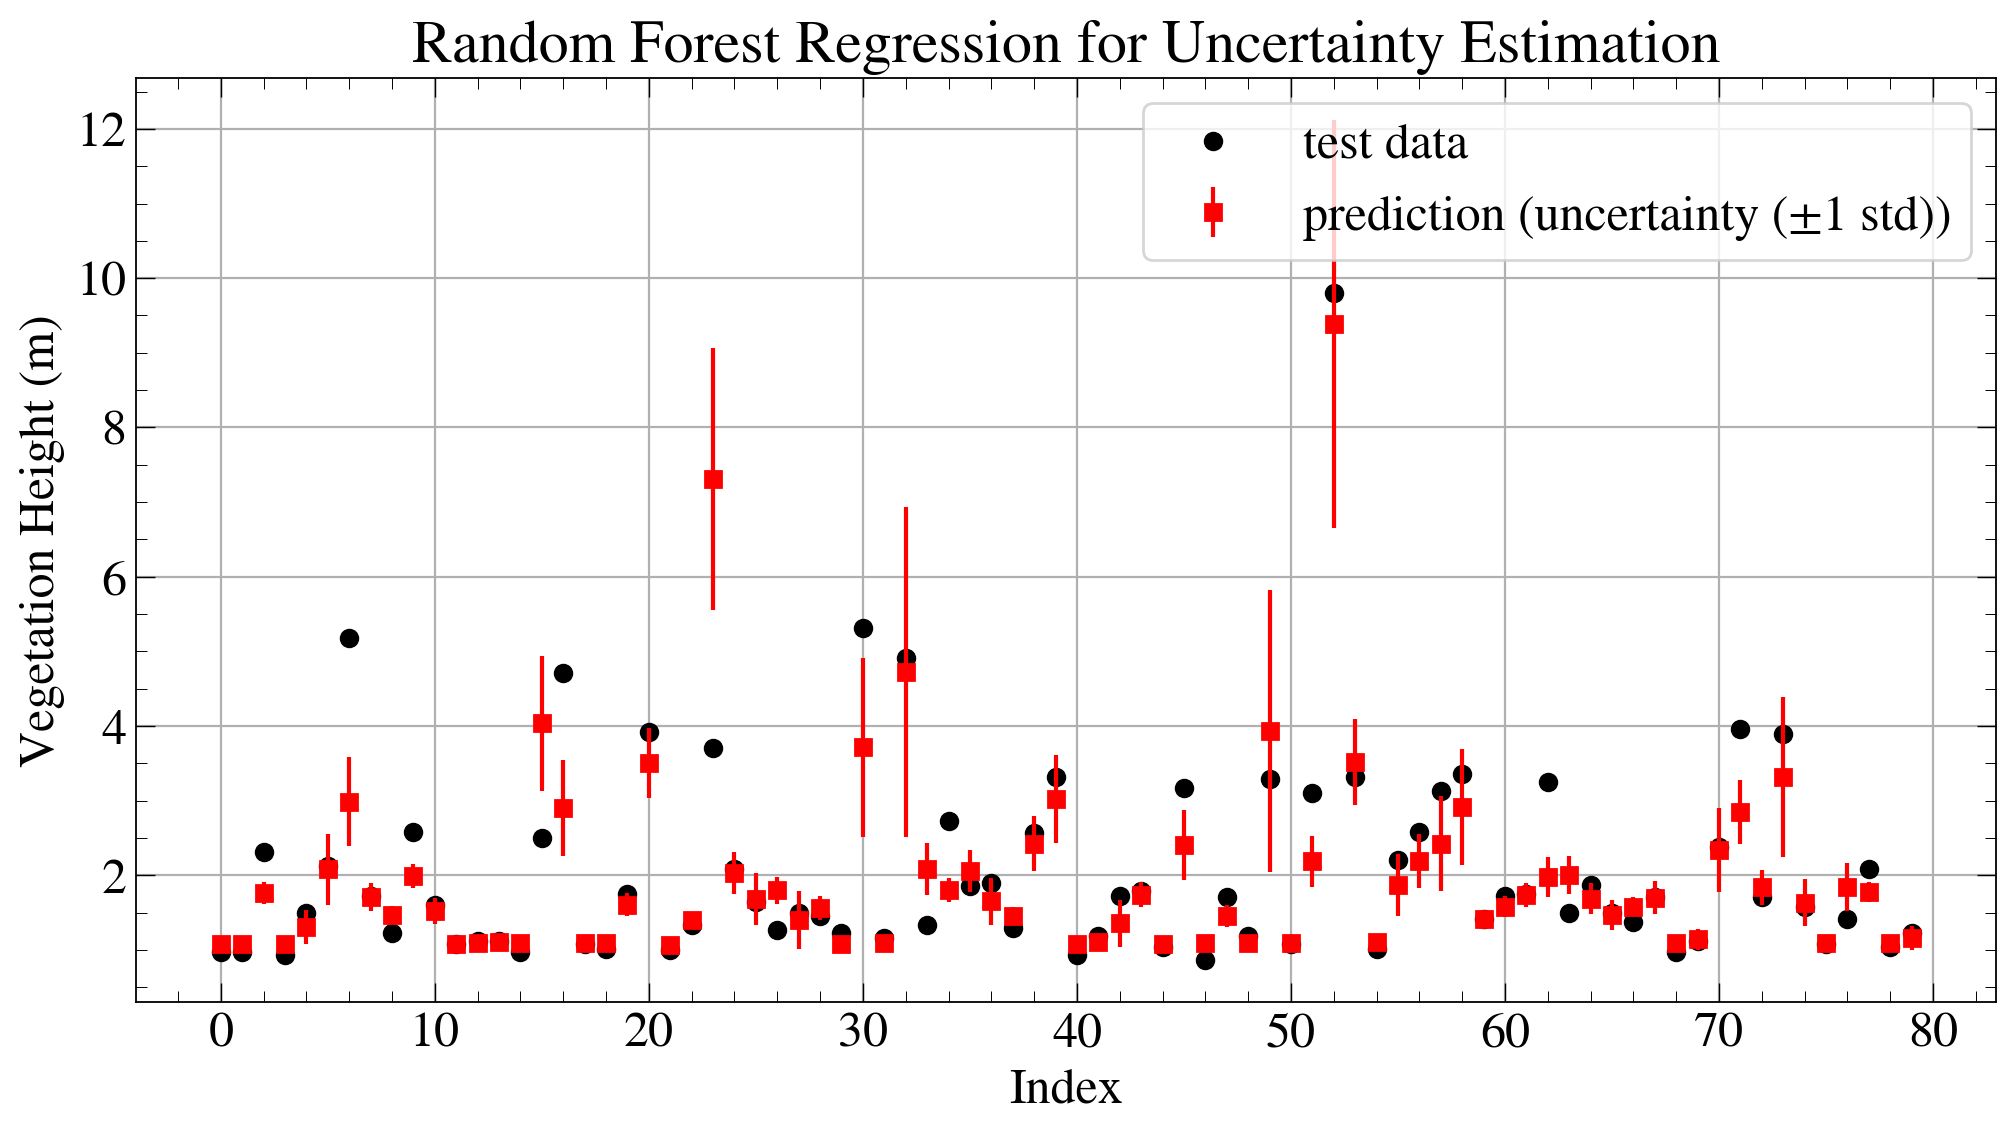

In [25]:
plt.figure(figsize=(12,6))
k = 80
plt.plot(y_test_copy[-k:], color="black", label="test data", marker = "o", linestyle="None")
plt.errorbar(list(range(k)), 
             y_pred_mean_rf[-k:], 
             yerr = y_pred_std_rf[-k:], 
             color="red", alpha=1.0, 
             label="prediction (uncertainty (±1 std))", 
             linestyle="None", fmt='s')

plt.xlabel("Index")
plt.ylabel("Vegetation Height (m)")
plt.legend()
plt.title("Random Forest Regression for Uncertainty Estimation")
plt.show()

### Scatter Plots

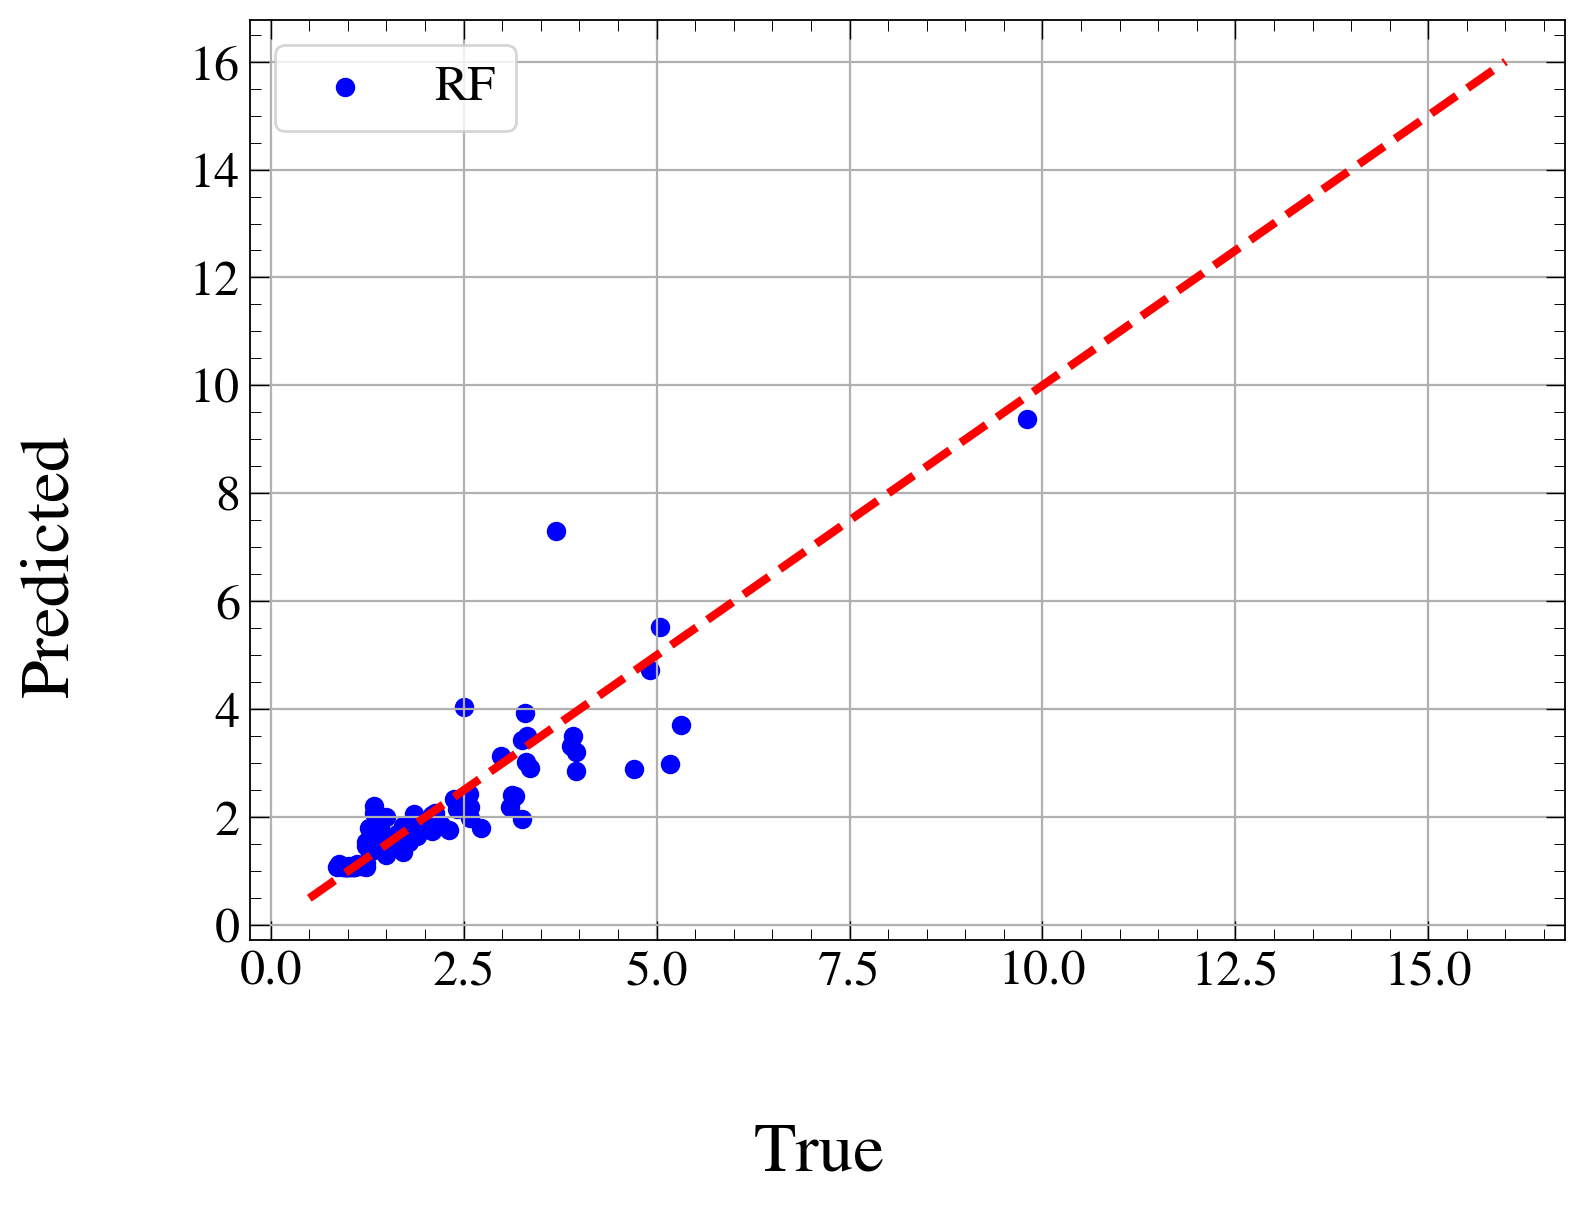

In [26]:
xx = np.linspace(0.5, 16)

# Create figure and subplots with shared y-axis
fig, axs = plt.subplots(figsize=(8, 6))

axs.scatter(y_test_copy, y_pred_mean_rf, color="blue", label = "RF")
axs.plot(xx, xx, color="red", linestyle="--", linewidth = 3)
# axs.set_title("True vs Predicted RF")
axs.legend()

#########################
# Super labels
fig.supxlabel(r"True", va="center", ha="center", fontsize=25)
fig.supylabel(r"Predicted", va="center", ha="center", fontsize=25)
# plt.suptitle("True vs Predicted", fontsize=18)

# Adjust layout
plt.tight_layout(h_pad=-1.0, w_pad=-0.7)
plt.show()

### Correlation Plot

Text(0.5, 1.0, 'RF')

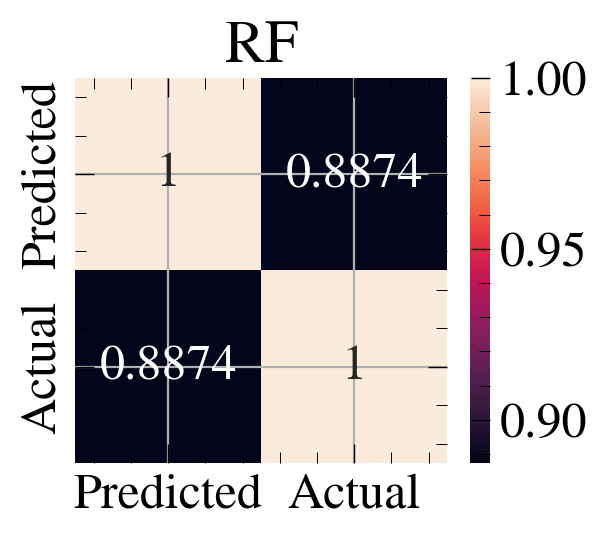

In [27]:
#-------------Correlation plot (MCD)
plt.figure(figsize = (3.0, 2.5))

#########################
#-------------Correlation plot (RF)
cor_rf = pd.DataFrame(y_pred_mean_rf).rename(columns = {0:"Predicted"})\
.join(pd.DataFrame(y_test_copy, columns = ['Actual']))

corrMatrix_rf = cor_rf.corr()
sns.heatmap(corrMatrix_rf, annot=True, fmt=".4g")
plt.title("RF")

### Predicition Errors

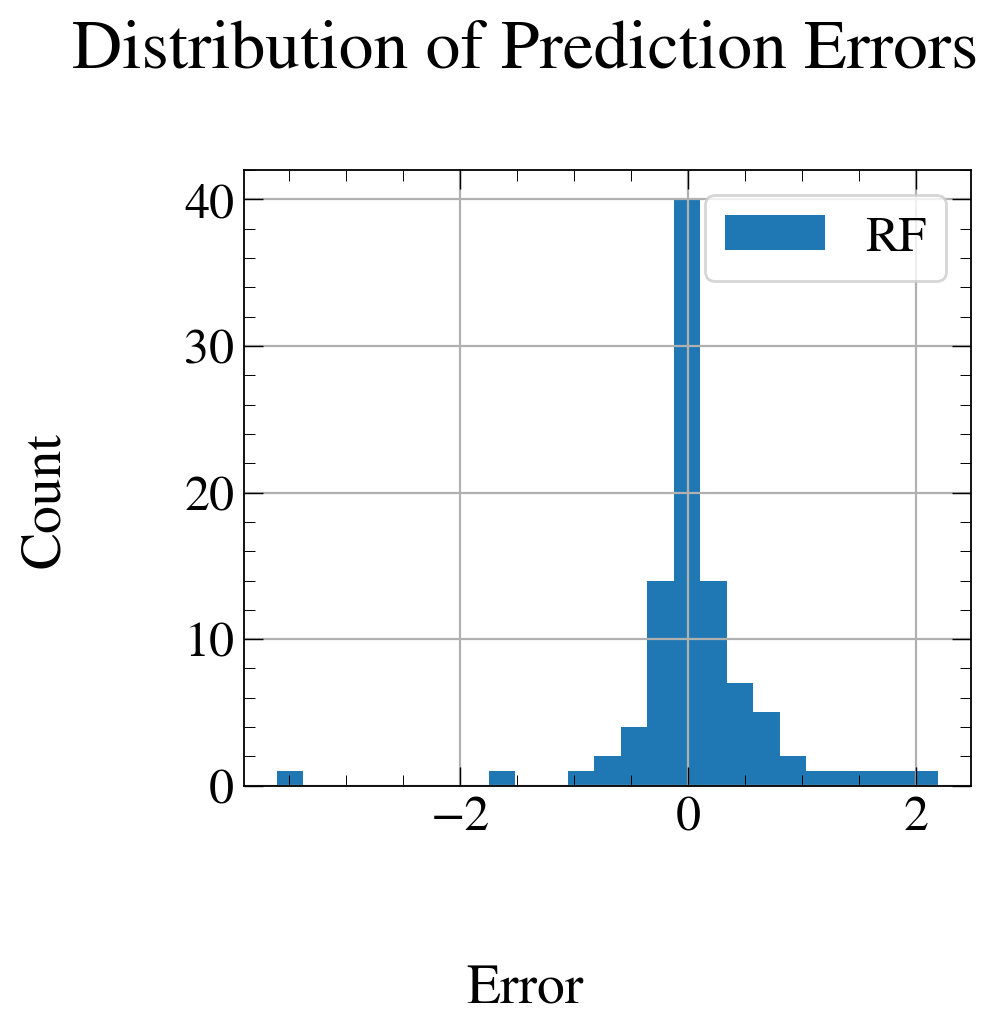

In [28]:
# Create subplots with shared y-axis
fig, axs = plt.subplots(figsize=(5, 5))

#########################
# Histogram of errors (RF)
error_rf = y_test_copy - y_pred_mean_rf
axs.hist(error_rf, bins=25, label = "RF")
# axs.set_title("Prediction Errors (RF)")
axs.legend()

# Super labels
fig.supxlabel(r"Error", va="center", ha="center", fontsize=20)
fig.supylabel(r"Count", va="center", ha="center", fontsize=20)
# Add a super title for the entire figure
plt.suptitle("Distribution of Prediction Errors", fontsize=25)

# Adjust layout
plt.tight_layout(h_pad = 0.0, w_pad = -0.6)
plt.show()


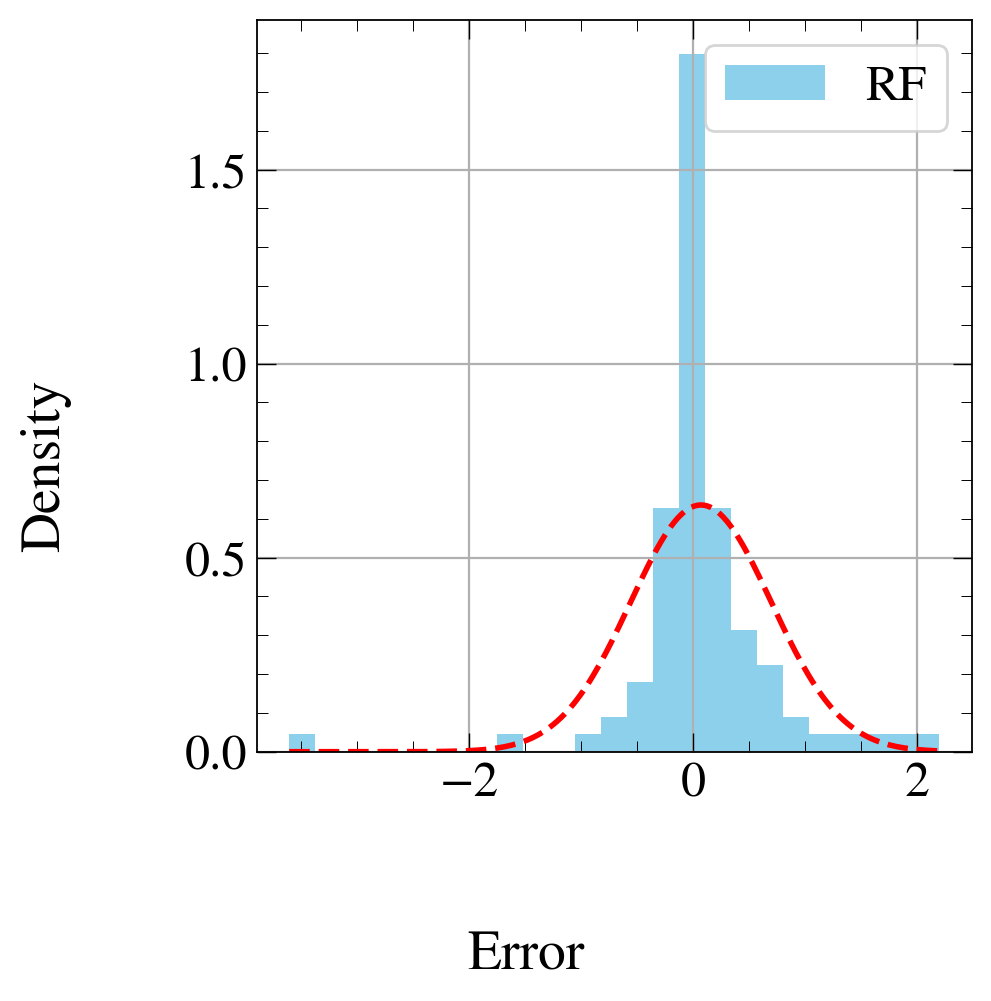

In [29]:
# Create subplots with shared y-axis
fig, axs = plt.subplots(figsize=(5, 5))

#########################
# Histogram + Density (RF)
error_rf = y_test_copy - y_pred_mean_rf
mu_rf, std_rf = np.mean(error_rf), np.std(error_rf)
x_rf = np.linspace(min(error_rf), max(error_rf), 200)
axs.hist(error_rf, bins=25, density=True, alpha=0.95, color="skyblue", label="RF")
axs.plot(x_rf, norm.pdf(x_rf, mu_rf, std_rf), "r--", linewidth=2)
# axs.set_title("Prediction Errors (RF)")
axs.legend()

# Super labels
fig.supxlabel("Error", va="center", ha="center", fontsize=20)
fig.supylabel("Density", va="center", ha="center", fontsize=20)
# plt.suptitle("Distribution of Prediction Errors with Normal Density", fontsize=25)

# Adjust layout
plt.tight_layout(h_pad=0.0, w_pad=-0.6)
plt.show()

### Compute R-Squared ($R^2$) and Compute Root Mean Square Error (RMSE) 

In [30]:
r2_rf = r2_score(y_test_copy, y_pred_mean_rf)
display(Math(f"R^2(RF) = {r2_rf}"))

rmse_rf = np.sqrt(mean_squared_error(y_test_copy, y_pred_mean_rf))
print("RMSE RF:", rmse_rf)

<IPython.core.display.Math object>

RMSE RF: 0.6313179021243391


### Variable Importance

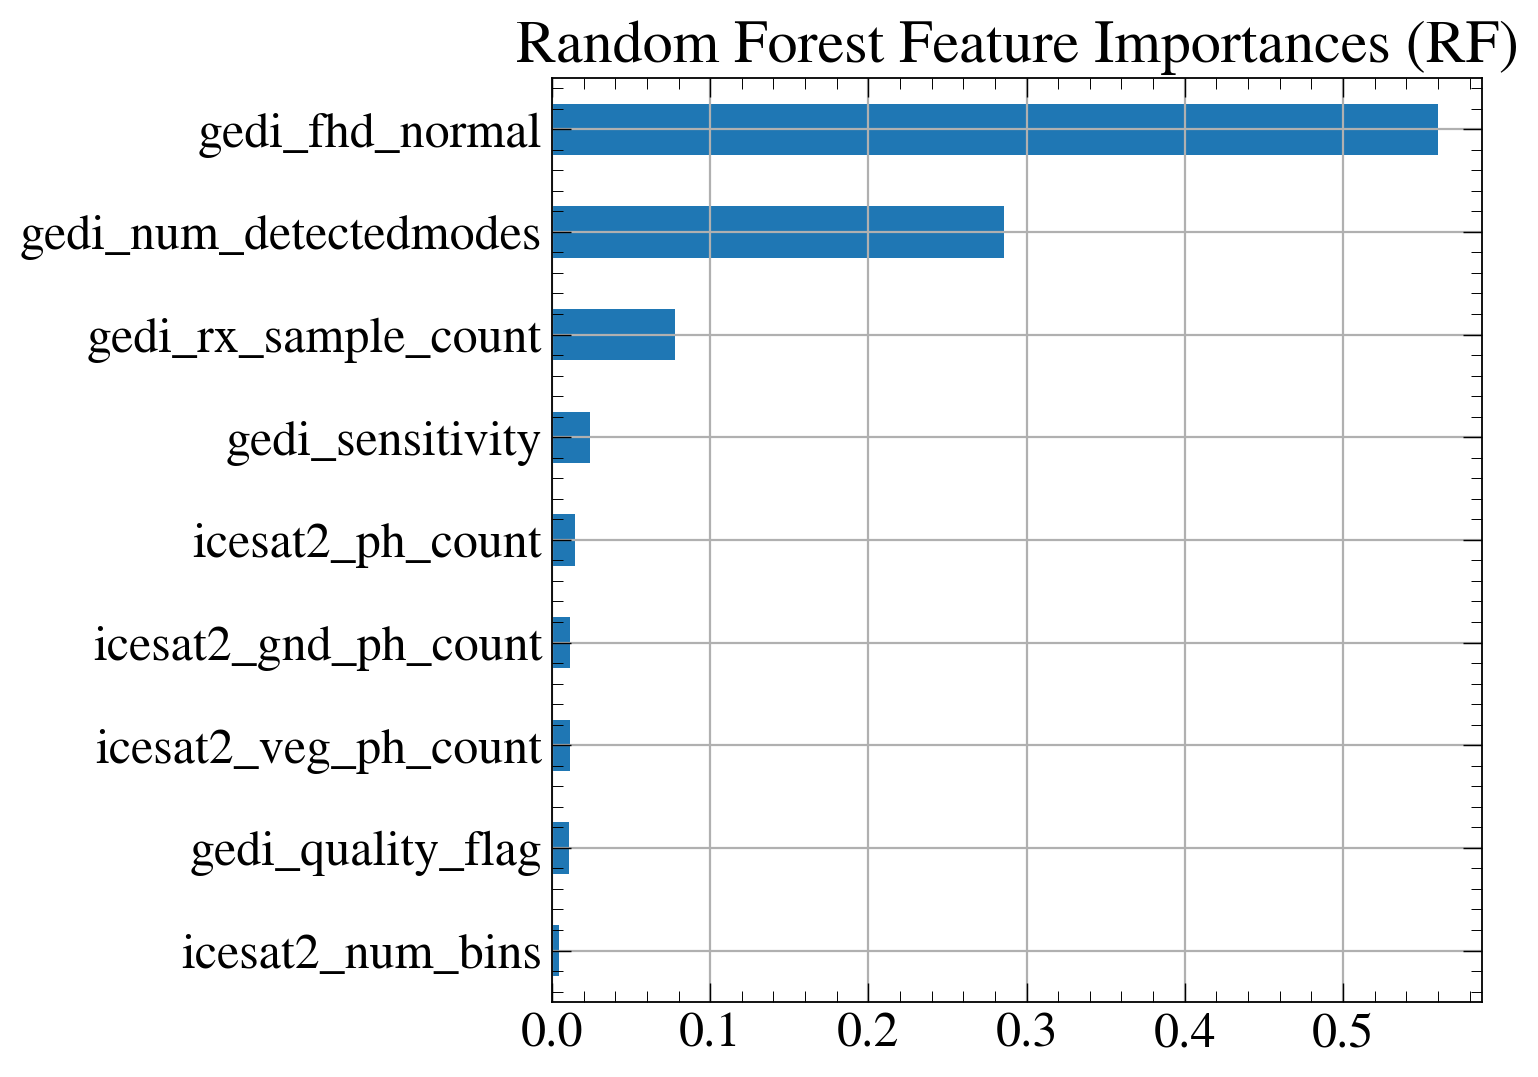

In [31]:
importances = rf_model.feature_importances_
new_cols = np.array(use_cols[:-2])  

# Plot
# pd.Series(importances).sort_values().plot(kind='barh')
pd.Series(importances, index=new_cols).sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importances (RF)")
plt.show()

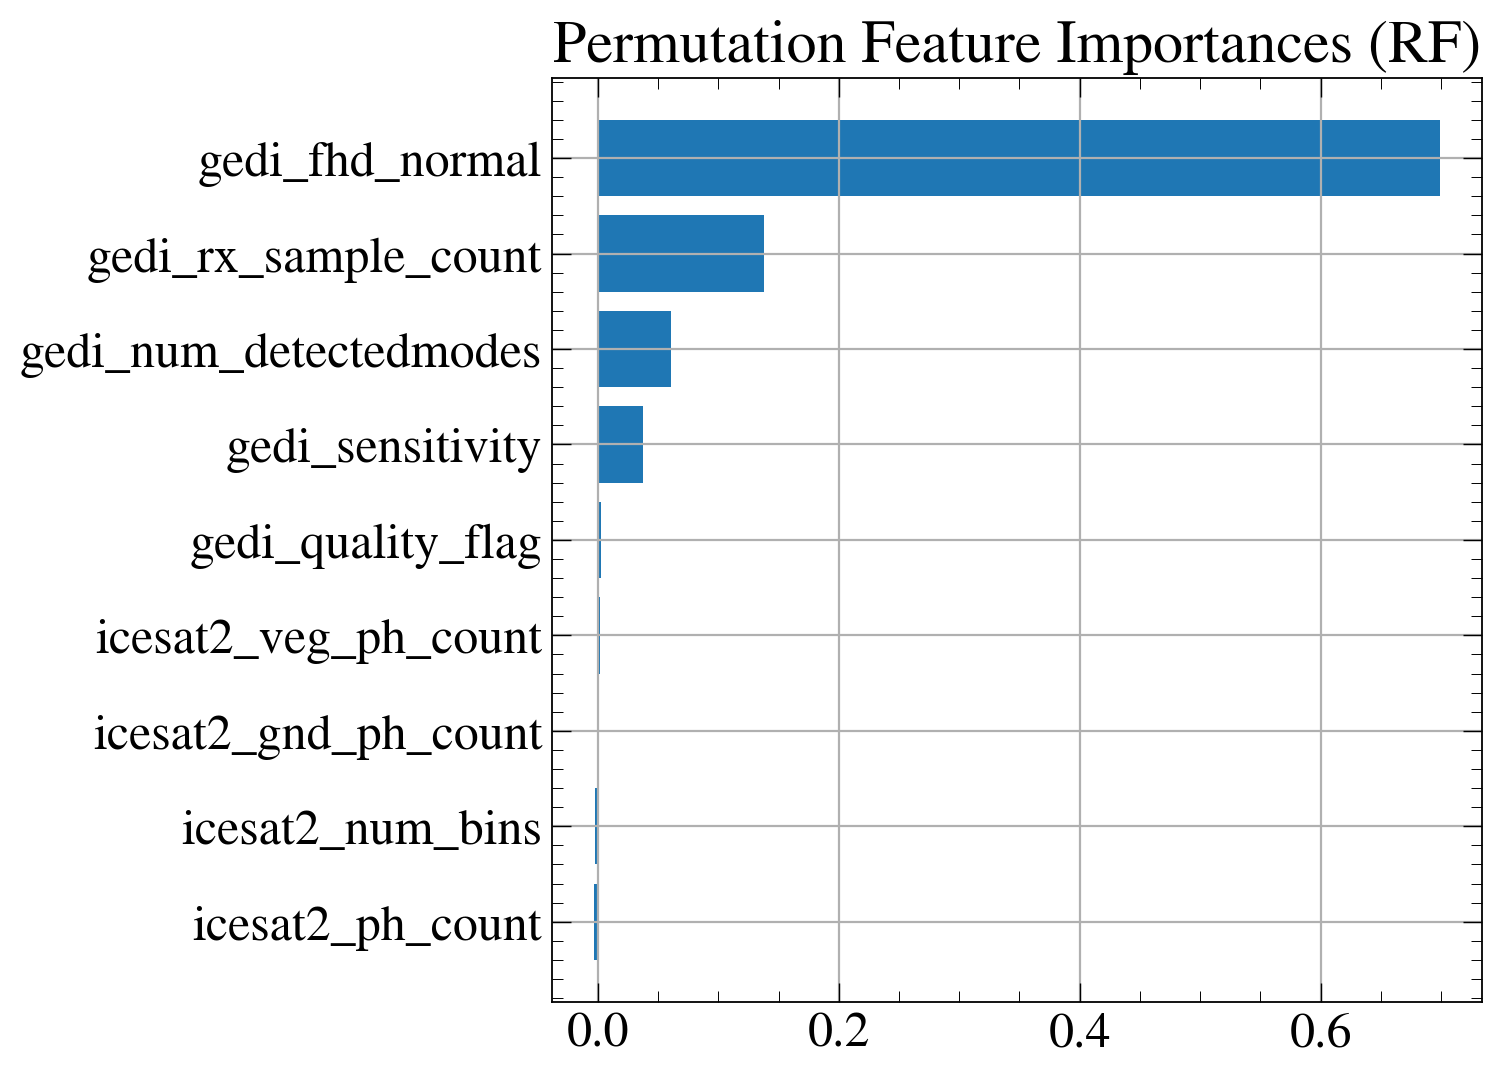

In [32]:
result = permutation_importance(rf_model, X_test_copy, y_test_copy, n_repeats=30, random_state=42, scoring='r2')
sorted_idx = result.importances_mean.argsort()

plt.barh(new_cols[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importances (RF)")
plt.show()